In [1]:
!pip install bayesian-optimization
import pandas as pd
from xgboost import XGBClassifier, cv
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.compose import ColumnTransformer
from bayes_opt import BayesianOptimization
import numpy as np

SEED=0


[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: pip install --upgrade pip


# Load the dataset
- Load data from excel sheet
- Set X (independent variables) and y (dependent variables) 

In [137]:
data_path = './data/master_4Mayhew.xlsx'
df = pd.read_excel(data_path)
df.set_index('SMILES', inplace=True)
y=df['label'] # labels, independent variables
X=df.drop(['label'], axis=1) # features, dependent variables

df

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2,label
SMILES,,,,,,,,,,,,,,,,,,,,,
C1=CC=C2C(=C1)C(=O)C(C2=O)(O)O,10.191572,9.610016,0,0,16.402096,2.535251,4.795559,16.402096,1.261700,3.521954,...,60.186518,178.026609,9.369822,209,23,72,89,5.506944,2.750000,False
C(=C(F)F)(C(F)(F)F)C(F)(F)F,8.786807,9.354315,0,0,11.264384,2.394170,4.788340,11.264384,0.938699,3.353751,...,43.053817,199.987226,16.665602,179,16,58,63,8.347222,2.444444,False
C1=C(C=C(C(=C1[N+](=O)[O-])O)[N+](=O)[O-])[N+](=O)[O-],11.877237,11.411786,0,0,18.380381,2.411142,4.822284,18.380381,1.148774,3.664511,...,48.280750,228.997099,12.052479,408,25,78,90,8.277778,3.555556,False
CN1C(=O)CN=C(C2=C1C=CC(=C2)Cl)C3=CC=CC=C3,15.682318,12.964430,0,0,26.034025,2.456696,4.859289,26.034025,1.301701,3.935426,...,61.882766,284.071641,8.608232,726,36,106,126,6.277778,4.388889,False
C(C(C(F)(F)F)(F)Cl)(F)Cl,7.220990,7.794227,0,0,9.758256,2.380983,4.761966,9.758256,0.975826,3.172059,...,40.351995,201.937546,18.357959,108,15,48,54,7.236111,2.062500,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCCCC(=O)OCC,5.766244,6.059284,0,0,10.383983,2.015316,4.030632,10.383983,1.153776,3.007982,...,35.041491,130.099380,5.656495,108,7,32,31,4.361111,2.416667,True
C=CCSS(=O)CC=C,5.766244,6.059284,0,0,10.383983,2.015316,4.030632,10.383983,1.153776,3.007982,...,35.041491,162.017307,8.527227,108,7,32,31,4.361111,2.416667,True
CCCC(=O)OCC(C)C,6.692130,6.855805,0,0,11.127090,2.052881,4.105762,11.127090,1.112709,3.123647,...,37.120200,144.115030,5.542886,143,8,38,37,5.222222,2.500000,True


In [3]:
df.describe()

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
count,865.000000,865.000000,865.000000,865.000000,865.000000,865.000000,865.000000,865.000000,865.000000,865.000000,...,865.000000,865.000000,865.000000,865.000000,865.000000,865.00000,865.000000,865.000000,858.000000,865.000000
mean,7.276908,6.894335,0.104046,0.067052,12.205152,2.088981,4.152585,12.205152,1.146352,3.063640,...,8.069476,39.174177,152.287403,8.109239,221.567630,11.07052,44.917919,48.427746,4.626886,2.476895
std,3.991268,3.246953,0.394751,0.319344,6.483015,0.340398,0.665934,6.483015,0.155949,0.574341,...,1.687440,12.156193,66.800469,7.067873,328.019108,9.73424,28.066950,34.772870,1.759080,1.053846
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.693147,...,0.000000,1.000000,16.031300,3.206260,0.000000,0.00000,0.000000,0.000000,1.250000,0.000000
25%,4.352030,4.736714,0.000000,0.000000,7.878462,1.956295,3.899712,7.878462,1.095322,2.752227,...,7.601402,32.187603,106.041865,5.580192,46.000000,4.00000,24.000000,24.000000,3.361111,1.750000
50%,6.801520,6.765664,0.000000,0.000000,11.342564,2.124117,4.202006,11.342564,1.174300,3.124521,...,8.298291,38.565088,144.115030,6.479693,120.000000,9.00000,40.000000,41.000000,4.361111,2.333333
75%,8.900428,8.519427,0.000000,0.000000,15.081987,2.292600,4.581552,15.081987,1.239221,3.395507,...,9.094144,45.012208,184.146330,8.062289,253.000000,15.00000,56.000000,62.000000,5.472222,3.000000
max,28.538901,20.779696,4.000000,4.000000,47.000875,2.724597,5.283099,47.000875,1.417947,4.523954,...,10.696050,88.394033,531.180395,126.904473,4692.000000,57.00000,194.000000,229.000000,14.375000,7.791667


# Explore the dataset

## How many missing values?

- There's 92 columns all NaNs
- 160 columns with > 90% NaNs

In [3]:
print(df.isna().mean(axis=0).nlargest(300))

SpAbs_Dt     1.000000
SpMax_Dt     1.000000
SpDiam_Dt    1.000000
SpAD_Dt      1.000000
SpMAD_Dt     1.000000
               ...   
AATS6m       0.213873
AATS6v       0.213873
AATS6se      0.213873
AATS6pe      0.213873
AATS6are     0.213873
Length: 300, dtype: float64


In [4]:
print(f"Number of columns with all NaNs \n{(df.isna().mean(axis=0) == 1).value_counts()}")

Number of columns with all NaNs 
False    1735
True       92
dtype: int64


In [5]:
print(f"Number of columns with >0.9 NaNs \n{(df.isna().mean(axis=0) > 0.9).value_counts()}")

Number of columns with >0.9 NaNs 
False    1667
True      160
dtype: int64


In [6]:
print(f"Number of columns with a NaN \n{ len(df.columns[df.isna().any()].tolist())}")

Number of columns with a NaN 
623


### Visualise number of NaNs in descriptors with missing values 

Text(0.5, 0, 'Percentage NaNs in descriptors with missing values')

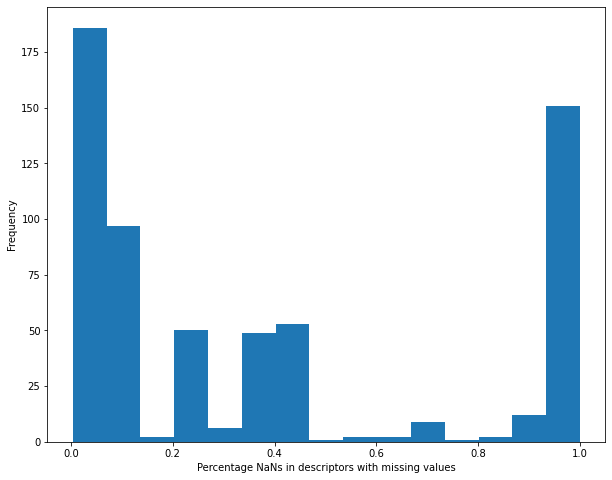

In [8]:
percs = df.isna().mean(axis=0)

ax = percs[(percs > 0)].plot.hist(figsize=(10, 8), bins=15)
plt.xlabel("Percentage NaNs in descriptors with missing values")

## Correlation between the descriptors

- degree to which features are related 
- https://jayant017.medium.com/hyperparameter-tuning-in-xgboost-using-randomizedsearchcv-88fcb5b58a73

In [4]:
# Remove descriptors of dataframe with > 50% nans
nans = df.isna().mean(axis=0)
# set threshold for percentage nans before we drop 
thresh = nans[nans >= 0.5]
df_corrs = df.copy()
df_corrs = df_corrs.drop(thresh.index, axis=1)
corrs = df_corrs.corr()
corrs

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2,label
ABC,1.000000,0.984817,0.002461,0.030907,0.989272,0.728026,0.735420,0.989272,0.528869,0.920121,...,0.882940,0.938751,-0.164554,0.853747,0.958762,0.991934,0.975321,0.784337,0.952894,-0.403256
ABCGG,0.984817,1.000000,0.017644,0.022007,0.966578,0.775729,0.781912,0.966578,0.529618,0.945448,...,0.903297,0.932150,-0.185056,0.798247,0.943907,0.974350,0.955708,0.841003,0.943962,-0.397517
nAcid,0.002461,0.017644,1.000000,0.220033,-0.026060,0.013846,0.020202,-0.026060,-0.108716,0.010658,...,-0.015430,0.016209,0.020762,-0.000492,-0.026008,-0.008421,-0.021712,0.119666,-0.010251,-0.219711
nBase,0.030907,0.022007,0.220033,1.000000,0.029622,-0.004723,-0.003677,0.029622,0.019905,-0.001987,...,0.009335,0.020061,-0.052047,0.087532,0.024540,0.032639,0.033790,0.011183,0.022760,-0.129745
SpAbs_A,0.989272,0.966578,-0.026060,0.029622,1.000000,0.686444,0.694428,1.000000,0.585872,0.911180,...,0.860329,0.925137,-0.191532,0.862143,0.940489,0.973580,0.954450,0.727824,0.974252,-0.369529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zagreb1,0.991934,0.974350,-0.008421,0.032639,0.973580,0.733251,0.736072,0.973580,0.509538,0.892694,...,0.888302,0.923774,-0.131867,0.836143,0.978751,1.000000,0.995078,0.768777,0.915895,-0.429542
Zagreb2,0.975321,0.955708,-0.021712,0.033790,0.954450,0.727515,0.726369,0.954450,0.500624,0.863221,...,0.884178,0.899164,-0.116056,0.813741,0.985556,0.995078,1.000000,0.740262,0.881352,-0.438329
mZagreb1,0.784337,0.841003,0.119666,0.011183,0.727824,0.614418,0.646097,0.727824,0.088493,0.745377,...,0.645128,0.825265,-0.058776,0.685694,0.779434,0.768777,0.740262,1.000000,0.773834,-0.429089
mZagreb2,0.952894,0.943962,-0.010251,0.022760,0.974252,0.625249,0.641950,0.974252,0.562932,0.897124,...,0.794815,0.920330,-0.214293,0.861128,0.883217,0.915895,0.881352,0.773834,1.000000,-0.328786


In [11]:
corrs.to_csv('descriptor-correlations.csv')  

## Extract correlation scores for important features

In [353]:
def corrs_important_features(model, X_test, model_name, nlargest=100, heatmap=14):
    feature_imp = pd.Series(model.feature_importances_,index=X_test.columns.values).sort_values(ascending=False)
    top_100 = feature_imp.nlargest(100)
    important_df = df.loc[:,top_100.index]
    corrs = important_df.corr()
    
    print(f"Extracted correlation scores for most important {nlargest} features for {model_name}")
    corrs.to_csv(f'correlations/descriptor-corrs-top{nlargest}-{model_name}.csv')  
    
    # Print heatmap for top n
    print(f"Printing heatmap for most important {heatmap} features")
    
    top_10 = feature_imp.nlargest(heatmap)
    important_df_10 = df.loc[:,top_10.index]
    corrs_10 = important_df_10.corr()
    
    plt.figure(figsize = (16,16))
    heatmap = sns.heatmap(corrs_10, vmin=-1, vmax=1, annot=True)
    # Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
    heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

## Clustering the dataset - Unsupervised learning

### Principal component analysis 
https://www.kaggle.com/code/kashnitsky/topic-7-unsupervised-learning-pca-and-clustering

In [237]:
from sklearn import decomposition

df_pca = df.copy()

nans =  X.columns[X.isna().any()].tolist()
X_no_nans = X.drop(nans, axis=1)
pca = decomposition.PCA(n_components=10)
pca_result = pca.fit_transform(X_no_nans)

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.86118022 0.04495109 0.03562341 0.01396448 0.01223102 0.00604978
 0.00446743 0.00378175 0.00272802 0.00216573]


Projecting 1203-dimensional data to 2D


<function matplotlib.pyplot.show(close=None, block=None)>

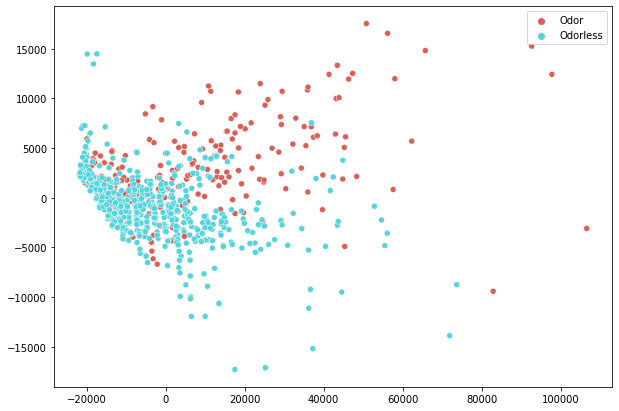

In [238]:
print('Projecting %d-dimensional data to 2D' % X_no_nans.shape[1])

plt.figure(figsize=(10,7))
ax = sns.scatterplot(
    x=pca_result[:,0], y=pca_result[:,1],
    hue=y,
    palette=sns.color_palette("hls", 2)
)
h,l = ax.get_legend_handles_labels()
ax.legend(h, ['Odor', 'Odorless'])
plt.show

Projecting 1203-dimensional data to 3D


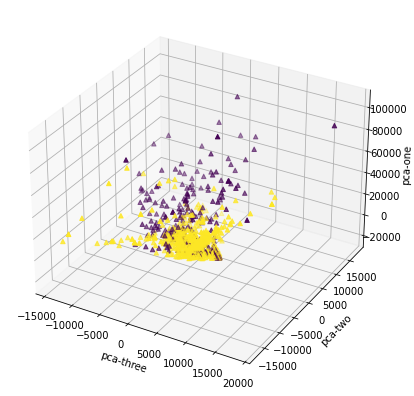

In [239]:
from mpl_toolkits import mplot3d

print('Projecting %d-dimensional data to 3D' % X_no_nans.shape[1])

plt.figure(figsize=(10,7))

ax = plt.axes(projection ="3d")
ax.scatter3D(
    xs=pca_result[:,2], 
    ys=pca_result[:,1], 
    zs=pca_result[:,0], 
    c=y, 
    marker ='^'
    
)

ax.set_xlabel('pca-three')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-one')
plt.show()

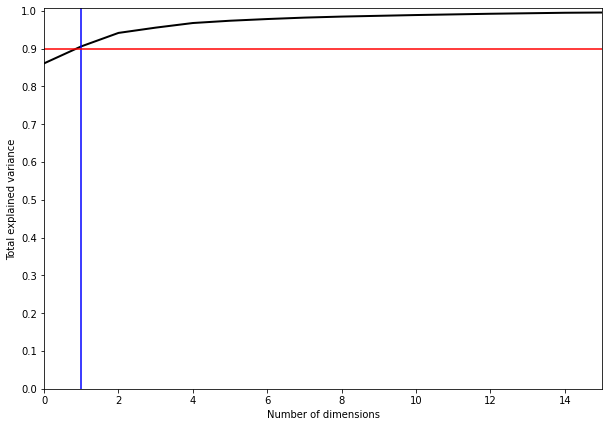

In [247]:
pca = decomposition.PCA().fit(X_no_nans)
plt.figure(figsize=(10,7))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of dimensions')
plt.ylabel('Total explained variance')
plt.xlim(0, 15)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(1, c='b')
plt.axhline(0.9, c='r')
plt.show();

In [241]:
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [8.61180215e-01 4.49510917e-02 3.56234148e-02 1.39644819e-02
 1.22310224e-02 6.04978316e-03 4.46742556e-03 3.78174687e-03
 2.72802109e-03 2.16573144e-03 1.91647699e-03 1.79666745e-03
 1.59078159e-03 1.45325373e-03 1.16664869e-03 6.85122333e-04
 5.25879821e-04 5.14294710e-04 3.94973867e-04 3.38257622e-04
 3.32656174e-04 2.70231135e-04 2.52162211e-04 2.06419663e-04
 1.88777889e-04 1.83052043e-04 1.45925361e-04 1.33974974e-04
 1.08132336e-04 8.92609648e-05 7.90976959e-05 6.36485626e-05
 4.68334260e-05 4.36026218e-05 3.74646398e-05 3.13315381e-05
 2.58934975e-05 2.44811746e-05 2.05867482e-05 1.81164701e-05
 1.71776229e-05 1.48769693e-05 1.46965948e-05 1.30489419e-05
 1.14688799e-05 9.85650311e-06 9.38682776e-06 7.98238757e-06
 7.65687669e-06 6.61941544e-06 5.84225116e-06 5.24375752e-06
 4.49908077e-06 4.30820649e-06 3.72004613e-06 3.35156947e-06
 3.10457307e-06 2.73923427e-06 2.47208751e-06 2.34346764e-06
 2.19013210e-06 1.50561361e-06 1.3528503

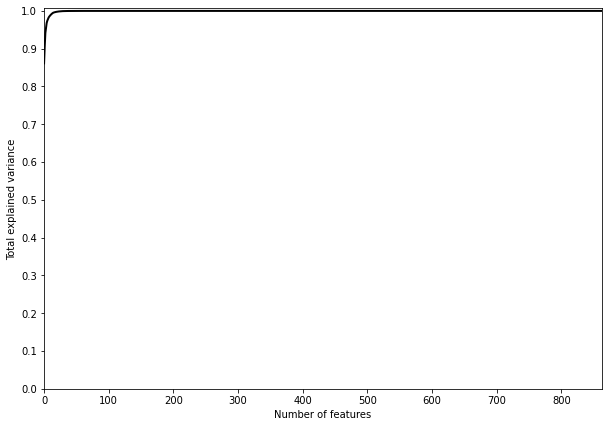

In [242]:
plt.figure(figsize=(10,7))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of features')
plt.ylabel('Total explained variance')
plt.xlim(0, 863)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.show();

### TSNE 

Unlike PCA, it's a probabilistic technique rather than probablistic. 

https://builtin.com/data-science/tsne-python

In [243]:
from sklearn.manifold import TSNE
import time

time_start = time.time()
tsne = TSNE(random_state=SEED, n_components=2, verbose=1, n_iter=300)
tsne_results = tsne.fit_transform(X_no_nans)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 865 samples in 0.003s...
[t-SNE] Computed neighbors for 865 samples in 0.093s...
[t-SNE] Computed conditional probabilities for sample 865 / 865
[t-SNE] Mean sigma: 2081.898082
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.323875
[t-SNE] KL divergence after 300 iterations: 0.756091
t-SNE done! Time elapsed: 0.8922524452209473 seconds


<AxesSubplot: >

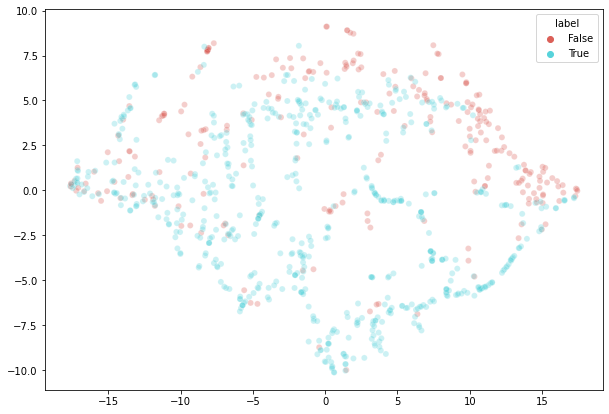

In [244]:
plt.figure(figsize=(10,7))
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue=y,
    palette=sns.color_palette("hls", 2),
    alpha=0.3
)

In [245]:
pca_5 = decomposition.PCA(n_components=5)
pca_result_5 = pca_5.fit_transform(X_no_nans)

print('Cumulative explained variation for 5 principal components: {}'.format(np.sum(pca_5.explained_variance_ratio_)))

Cumulative explained variation for 5 principal components: 0.9679502258731705


Varying perplexity 5
t-SNE done! Time elapsed: 1.5190012454986572 seconds


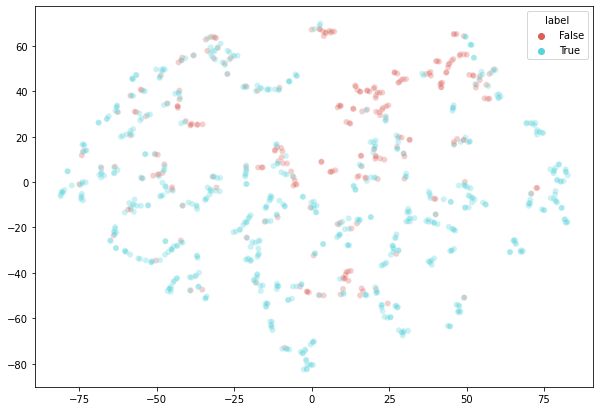

Varying perplexity 10
t-SNE done! Time elapsed: 1.6150212287902832 seconds


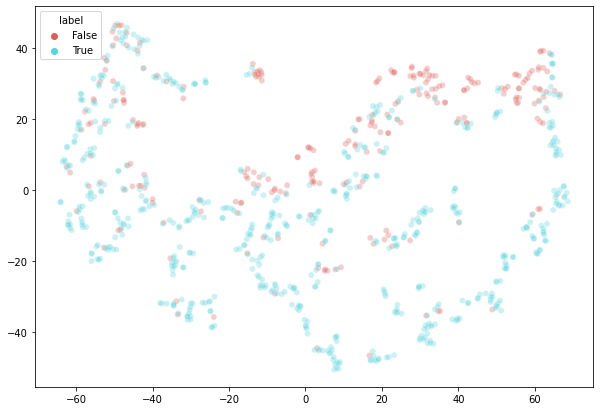

Varying perplexity 15
t-SNE done! Time elapsed: 1.7800886631011963 seconds


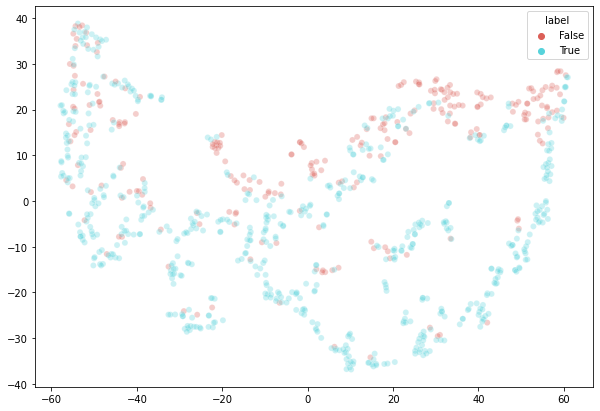

Varying perplexity 20
t-SNE done! Time elapsed: 1.6439063549041748 seconds


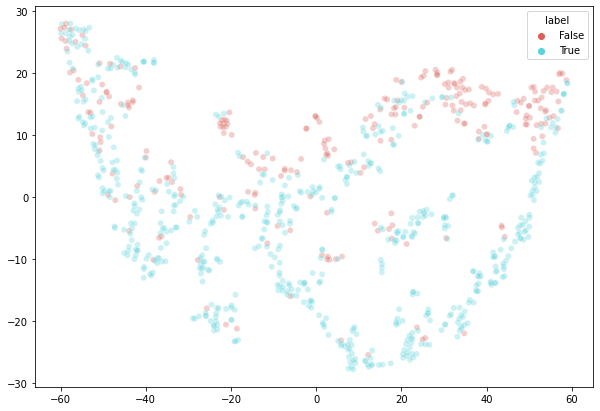

Varying perplexity 25
t-SNE done! Time elapsed: 1.7942538261413574 seconds


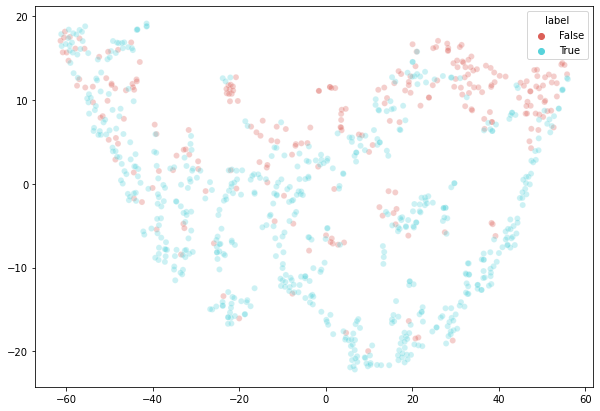

Varying perplexity 30
t-SNE done! Time elapsed: 1.7821967601776123 seconds


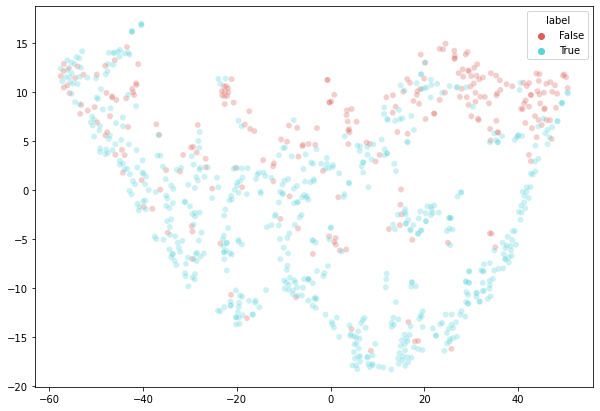

Varying perplexity 35
t-SNE done! Time elapsed: 2.053743362426758 seconds


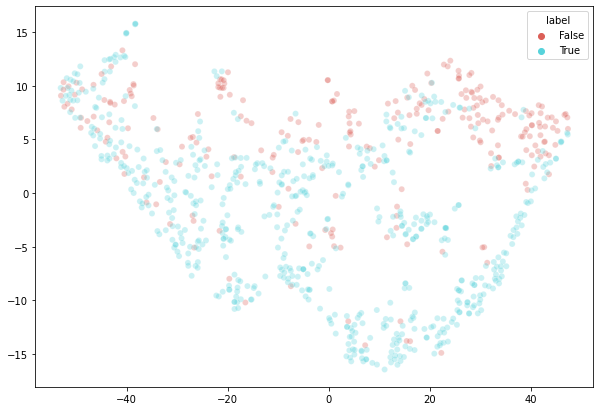

Varying perplexity 40
t-SNE done! Time elapsed: 1.9195630550384521 seconds


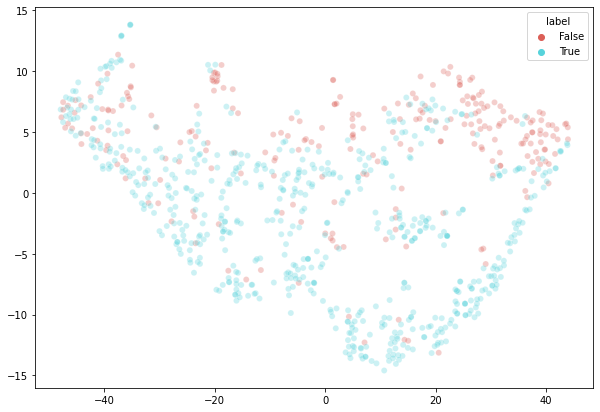

Varying perplexity 45
t-SNE done! Time elapsed: 1.9550251960754395 seconds


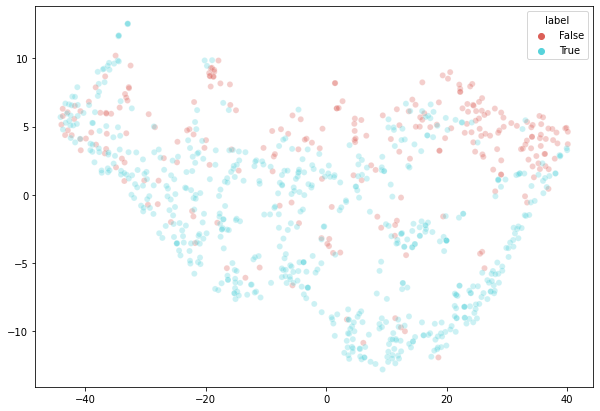

Varying perplexity 50
t-SNE done! Time elapsed: 2.9269752502441406 seconds


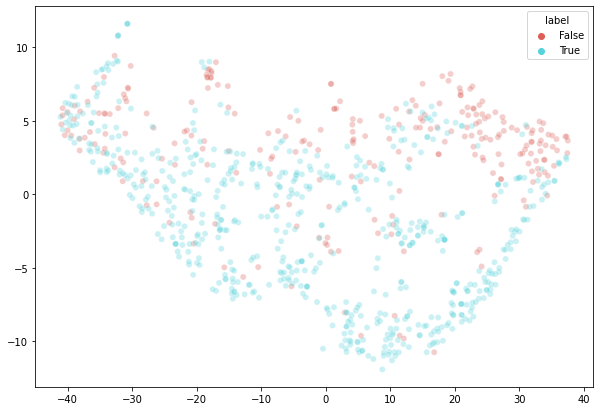

Varying perplexity 55
t-SNE done! Time elapsed: 2.3405635356903076 seconds


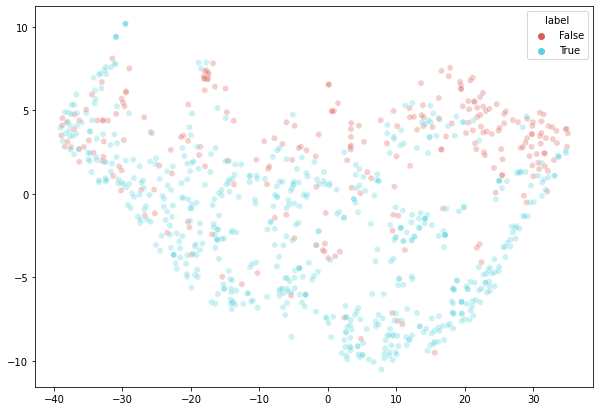

Varying perplexity 60
t-SNE done! Time elapsed: 2.481520652770996 seconds


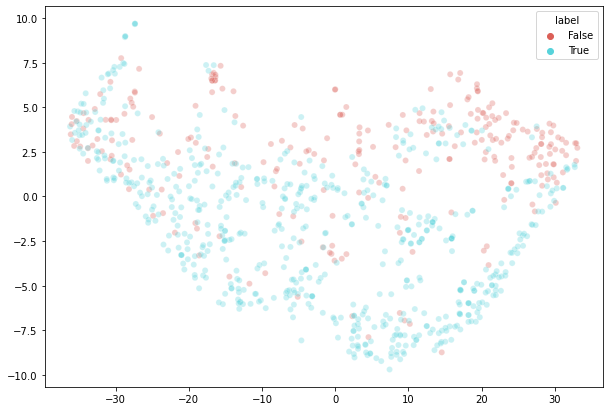

Varying perplexity 65
t-SNE done! Time elapsed: 2.349072217941284 seconds


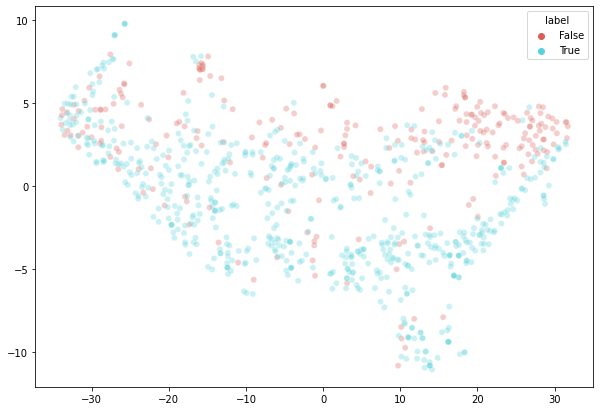

Varying perplexity 70
t-SNE done! Time elapsed: 2.3233656883239746 seconds


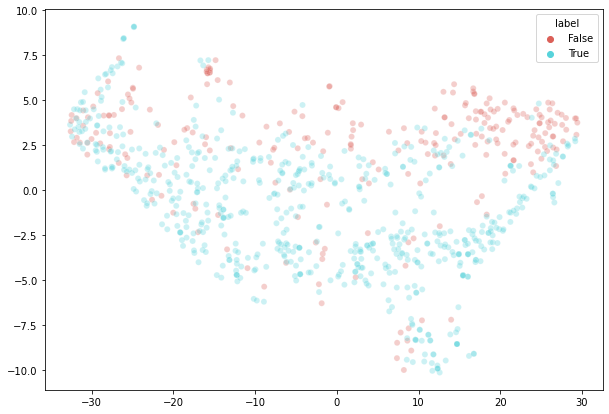

Varying perplexity 75
t-SNE done! Time elapsed: 2.596748113632202 seconds


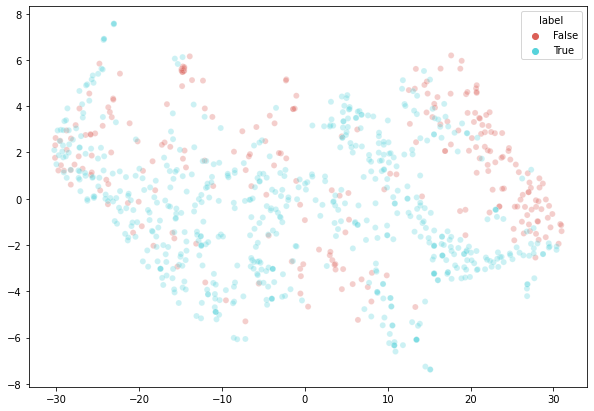

Varying perplexity 80
t-SNE done! Time elapsed: 2.652697801589966 seconds


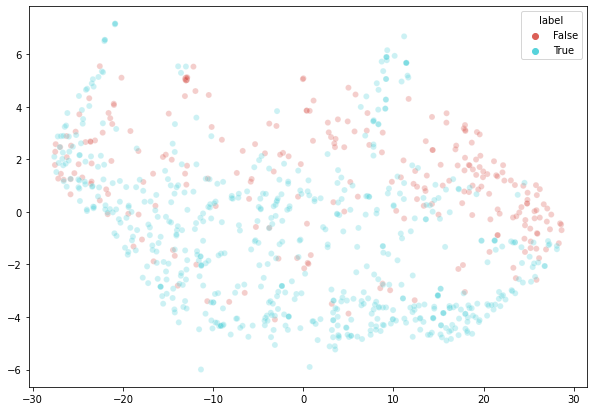

Varying perplexity 85
t-SNE done! Time elapsed: 2.8677382469177246 seconds


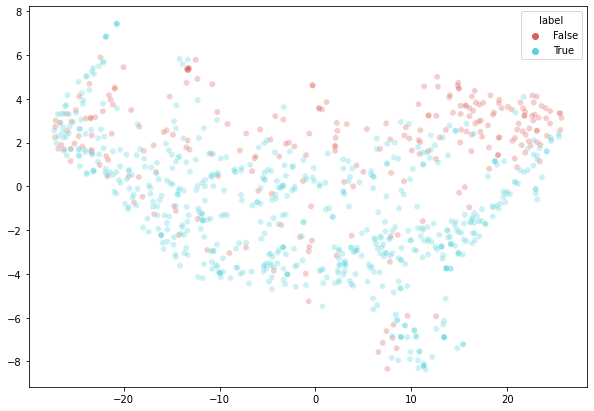

Varying perplexity 90
t-SNE done! Time elapsed: 2.915170431137085 seconds


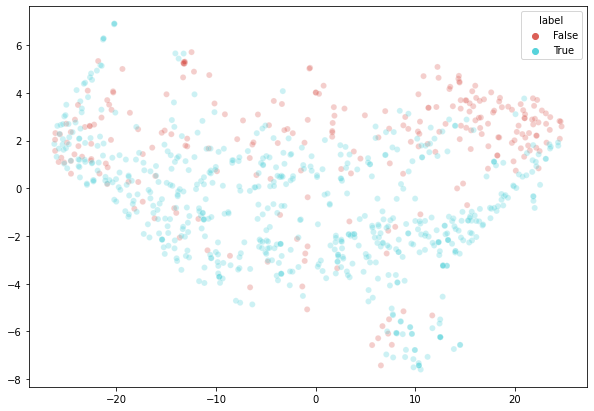

Varying perplexity 95
t-SNE done! Time elapsed: 2.8575143814086914 seconds


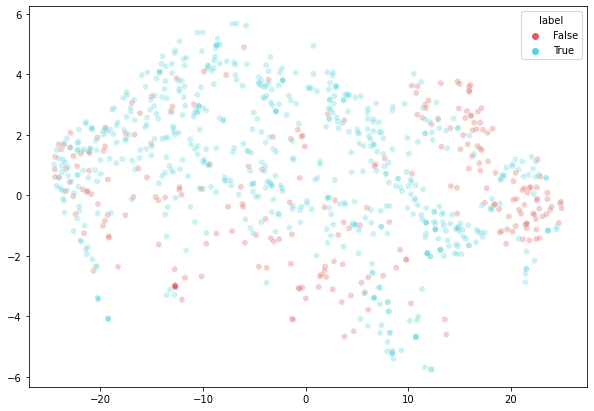

In [246]:
time_start = time.time()

for perpelixity in range(5, 100, 5):
    
    print(f"Varying perplexity {perpelixity}")
    
    time_start = time.time()

    tsne = TSNE(verbose=0, perplexity=perpelixity)
    tsne_pca_results = tsne.fit_transform(pca_result_5)

    print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

    plt.figure(figsize=(10,7))
    sns.scatterplot(
        x=tsne_pca_results[:,0], y=tsne_pca_results[:,1],
        hue=y,
        palette=sns.color_palette("hls", 2),
        alpha=0.3
    )
    plt.show()

### K-Means Clustering

# Split the dataset
- Split dataset into training and test set 
- Use equal proportions of odor/odorless class

In [250]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0) # 70% training and 30% test
percentage_odorless = y_train.value_counts()[False]/y_train.shape[0]
percentage_odor = 1 - percentage_odorless
print(f"Total number molecules in training set: {y_train.shape[0]}")
print(f"Odor: {y_train.value_counts()[True]}")
print(f"Odorless: {y_train.value_counts()[False]}")

print(f"\nTotal number molecules in test set: {y_test.shape[0]}")
print(f"Odor: {y_test.value_counts()[True]}")
print(f"Odorless: {y_test.value_counts()[False]}")

print(f"\nPercentage odorless {y_test.value_counts()[False]/y_test.shape[0]}")

Total number molecules in training set: 692
Odor: 492
Odorless: 200

Total number molecules in test set: 173
Odor: 123
Odorless: 50

Percentage odorless 0.28901734104046245


### Validation set

In [282]:
X_train_t, X_val, y_train_t, y_val = train_test_split(X_train, y_train, test_size=0.3, stratify=y_train, random_state=SEED)

print("Number of training samples:", len(X_train_t))
print("Number of validation samples:", len(X_val))

Number of training samples: 484
Number of validation samples: 208


# Test Model 

In [278]:
def test_model(model, y_test, X_test, verbose=True):
    y_pred=model.predict(X_test)
    y_pred_probs=model.predict_proba(X_test)[:,1]
    
    if verbose:
        print("ROC_AUC (TEST):",metrics.roc_auc_score(y_test, y_pred_probs))
        print("\n\nCLASSIFICATION REPORT:\n",metrics.classification_report(y_test, y_pred))
        
        if hasattr(model, 'feature_importances_') and hasattr(X_test, 'columns'):
            feature_imp = pd.Series(model.feature_importances_,index=X_test.columns.values).sort_values(ascending=False)
            top_20 = feature_imp.nlargest(20)
            sns.barplot(x=top_20, y=top_20.index)
            plt.xlabel('Descriptor Importance Score')
            plt.ylabel('Descriptor')
            plt.title("Top descriptors")
            plt.show()
        
        fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_probs)  
        
        #create ROC curve
        plt.plot(fpr,tpr)
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()
        
    return metrics.roc_auc_score(y_test, y_pred_probs) 

# Handle Non Important Descriptors 

1. Remove values below threshold e.g. 0, any descriptors with 0 importance
2. Get the top N descriptors

In [252]:
def handle_importance(model, X_train, X_test, threshold=-1, n=-1, verbose=None):
    feature_imp = pd.Series(model.feature_importances_,index=X_train.columns.values).sort_values(ascending=False)
    if threshold >= 0:
        feature_imp = feature_imp[feature_imp > threshold]
    
    if n >= 0: 
        feature_imp = feature_imp.nlargest(n)
        
    if verbose: 
        print(feature_imp)
        
    X_train = X_train.loc[:, feature_imp.axes[0].tolist()]
    X_test = X_test.loc[:, feature_imp.axes[0].tolist()]

    return X_train, X_test, model 

In [253]:
imp_params = [
#               {"threshold":0, 'n':-1},
#               {"threshold":0.001, 'n':-1},
#               {"threshold":0.01, 'n':-1},
              {"threshold":-1, 'n':5}, 
              {"threshold":-1, 'n':10}, 
              {"threshold":-1, 'n':25}, 
              {"threshold":-1, 'n':50},
              {"threshold":-1, 'n':100}, 
              {"threshold":-1, 'n':200}, 
              {"threshold":-1, 'n':400}, 
              {"threshold":-1, 'n':800},
              {"threshold":-1, 'n':1203}]

# These descriptors must be included in every experiment 
check_descriptors = ['TopoPSA(NO)', 'nHetero', 'nHBDon', 'ATS4P', 'NsCH3', 'IC3', 'EState_VSA6', 'AATSOV', 'NsOH','SpAD_DzZ', 'SM1_DZ(v)']

def optimiseImportance(model, X_train, X_test, y_train, y_test, k=5, verbose=True):
    print(f"Cross validated importance experiment with k={k}")
    
    imp_df = pd.DataFrame(columns=['Most important N descriptors', 'Average ROC_AUC', 'Standard Deviation'])

    for imp_param in imp_params: 
        name = (f"Threshold:{imp_param['threshold']}N:{imp_param['n']}".replace("N:-1", '')).replace("Threshold:-1", '')
        print(name)

        X_train_cv, _, _ = handle_importance(model, 
                                            X_train.copy(), 
                                            X_test.copy(), 
                                            threshold=imp_param['threshold'], 
                                            n=imp_param['n'])
        

#         if not set(check_descriptors).issubset(set(X_train_fold.columns.values.tolist())): 
#             continue
#         else:
        roc_auc_nans = cross_val_score(model, X_train_cv, y_train, cv=k, scoring='roc_auc')
        
        imp_df = imp_df.append({'Most important N descriptors': imp_param['n'], 
                               'Average ROC_AUC':np.mean(roc_auc_nans), 
                               'Standard Deviation':np.std(roc_auc_nans)}, 
                                ignore_index = True)

    if verbose:
        fig = imp_df.plot(kind="bar", x="Most important N descriptors", y="Average ROC_AUC", yerr="Standard Deviation", title=f"ROC_AUC after filtering descriptors by importance CV={k}", legend=False)
        
        plt.ylim(0.90,1)
        
    return imp_df

# Handle NaNs


- You cannot have any missing values in the random forest model, you can in XGB
- You cannot have mismatched features between columns in the random forest model
- 3 options 
    1. Remove any columns with missing values 
    2. Remove columns above threshold percentange NaNs e.g. 60% NaNs. 
    3. Remove columns above threshold percentange NaNs e.g. 60% NaNs. Replace columns below threshold with missing values with the mean value.

In [254]:
def handleNaNs(X_tr, X_te, option=1, thresh=0.6): 
    if option == 1:
        nans =  X.columns[X.isna().any()].tolist()
        X_tr.drop(nans, inplace = True, axis=1)
        X_te.drop(nans, inplace = True, axis=1)
    else: 
        nans = X.isna().mean(axis=0)
        # set threshold for percentage nans before we drop 
        X_thresh = nans[nans >= thresh]
        X_tr.drop(X_thresh.index, 
          axis=1, 
          inplace=True)
        X_te.drop(X_thresh.index, 
          axis=1, 
          inplace=True)
        
        if option == 3: 
            X_tr.fillna(X_train.mean(), inplace=True) 
            X_te.fillna(X_test.mean(), inplace=True)
    
    return X_tr, X_te

In [255]:
def optimiseNaNs(model, X_train, X_test, y_train, y_test, option=2, k=5, verbose=True): 
    print(f"Cross validated missing values experiment with k={k}")
    
    percentages = [x/100 for x in range(0, 100, 10)] 
    nans_df = pd.DataFrame(columns=['Name', 'Average ROC_AUC', 'Standard Deviation'])

    for perc in percentages: 
        name = str(perc)
        if perc == 0:
            X_train_cv, _  = handleNaNs(X_train.copy(), X_test.copy(), option=1)
        else:
            X_train_cv, _  = handleNaNs(X_train.copy(), X_test.copy(), option=option, thresh=perc)

        roc_auc_nans = cross_val_score(model, X_train_cv, y_train, cv=k, scoring='roc_auc')
        
        nans_df = nans_df.append({'Name': name, 
                                   'Average ROC_AUC':np.mean(roc_auc_nans), 
                                   'Standard Deviation':np.std(roc_auc_nans)}, 
                                    ignore_index = True)

    if verbose:
        fig = nans_df.plot(kind="bar", x="Name", y="Average ROC_AUC", yerr="Standard Deviation", title=f"ROC_AUC after thresholding descriptors by % NaNs CV={k}", legend=False)
        plt.ylim(0.95,0.98)
        
    return nans_df

# Random Forest Model

https://www.datacamp.com/tutorial/random-forests-classifier-python

In [309]:
# set random state to 0 to allow reproducible results
clf=RandomForestClassifier(random_state=SEED) 

# For readability
y_train_rf = y_train
y_test_rf = y_test
X_train_rf = X_train
X_test_rf = X_test

## Handle NaNs RF

Cross validated missing values experiment with k=5


,Name,Average ROC_AUC,Standard Deviation
0,0.0,0.970784,0.003906
1,0.1,0.968146,0.002932
2,0.2,0.968500,0.005369
3,0.3,0.967892,0.003344
4,0.4,0.967466,0.004047
5,0.5,0.964738,0.006947
6,0.6,0.967132,0.002913
7,0.7,0.967452,0.004857
8,0.8,0.968936,0.004855
9,0.9,0.963971,0.004127


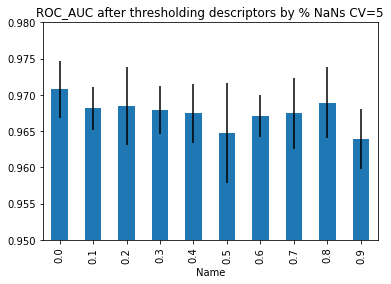

In [34]:
# choose optimal threshold for removing columns with NaNs
optimiseNaNs(clf, X_train_rf, X_test_rf, y_train_rf, y_test_rf, option=3)

It seems to have a very high standard deviation, so let's just go with removing all the columns with missing values

In [311]:
X_train_rf, X_test_rf = handleNaNs(X_train.copy(), X_test.copy(), option=1)
X_train_t_rf, X_val_rf = handleNaNs(X_train_t.copy(), X_val.copy(), option=1)

In [285]:
X_train_t_rf

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW09,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb2
SMILES,,,,,,,,,,,,,,,,,,,,,
CCCCOC(=O)C,5.168527,5.361851,0,0,8.762573,1.949856,3.899712,8.762573,1.095322,2.887985,...,0.0,7.475906,33.090360,116.083730,5.804186,79,5,28,26,2.083333
CC1=CN=C(C=N1)C,5.875634,5.525875,0,0,9.924777,2.170086,4.340173,9.924777,1.240597,2.979730,...,0.0,8.463159,35.730685,108.068748,6.754297,62,7,36,38,1.833333
C1=CC(=CC=C1Cl)Cl,5.875634,5.525875,0,0,9.924777,2.170086,4.340173,9.924777,1.240597,2.979730,...,0.0,8.463159,35.730685,145.969006,12.164084,62,7,36,38,1.833333
CC1=CC(=O)CC(C1)(C)C,7.607685,7.212008,0,0,10.698196,2.326846,4.653693,10.698196,1.069820,3.214580,...,0.0,9.169623,40.037455,138.104465,5.754353,109,11,50,54,2.083333
CCC1=C(C(=CC=C1)CC)N(COC)C(=O)CCl,12.675551,12.434286,0,0,22.709704,2.405570,4.811139,22.709704,1.261650,3.765835,...,0.0,9.618934,50.388965,269.118257,7.082059,569,28,82,95,4.527778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCCCCCCCC=O,6.363961,6.254644,0,0,12.053348,1.918986,3.837972,12.053348,1.205335,3.105180,...,0.0,7.466799,35.643477,142.135765,5.076277,165,7,34,32,2.750000
CCCCCCCCCCCC(=O)OC,10.008885,8.957861,0,0,18.169374,2.017464,4.034927,18.169374,1.211292,3.524117,...,0.0,8.245122,43.650894,214.193280,5.224226,538,13,56,55,3.916667
C(CCCCC(=O)O)CCCC(=O)O,9.629947,8.672233,2,0,16.053348,2.000000,4.000000,16.053348,1.146668,3.460649,...,0.0,8.241967,42.543530,202.120509,6.316266,433,11,54,52,3.416667


Validation performance of Random Forest after removing all columns with NaNs
ROC_AUC (TEST): 0.9749436936936936


CLASSIFICATION REPORT:
               precision    recall  f1-score   support

       False       0.88      0.85      0.86        60
        True       0.94      0.95      0.95       148

    accuracy                           0.92       208
   macro avg       0.91      0.90      0.91       208
weighted avg       0.92      0.92      0.92       208



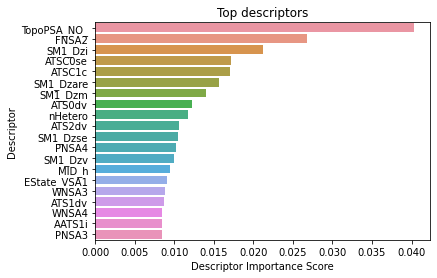

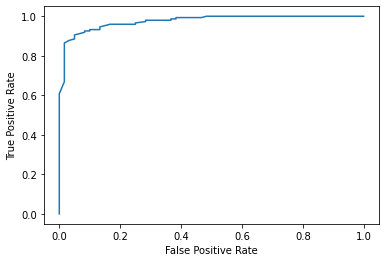

0.9749436936936936

In [287]:
clf.fit(X_train_t_rf, y_train_t)
print("Validation performance of Random Forest after removing all columns with NaNs")
test_model(clf, y_val, X_val_rf)

## Using PCA to reduce dimensionality

Validation performance of Random Forest after reducing dimensionality with PCA
ROC_AUC (TEST): 0.9368243243243243


CLASSIFICATION REPORT:
               precision    recall  f1-score   support

       False       0.81      0.72      0.76        60
        True       0.89      0.93      0.91       148

    accuracy                           0.87       208
   macro avg       0.85      0.82      0.84       208
weighted avg       0.87      0.87      0.87       208



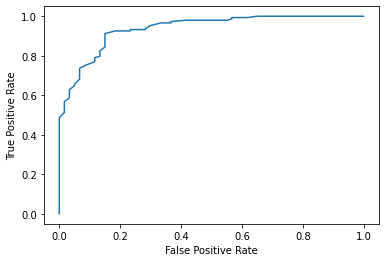

0.9368243243243243

In [304]:
pca = decomposition.PCA(n_components=35)

pca_result_t = pca.fit_transform(X_train_t_rf)
pca_result_val = pca.transform(X_val_rf)

clf.fit(pca_result_t, y_train_t)
print("Validation performance of Random Forest after reducing dimensionality with PCA")
test_model(clf, y_val, pca_result_val)

## Using Importance to reduce dimensionality

Cross validated importance experiment with k=5
N:5
N:10
N:25
N:50
N:100
N:200
N:400
N:800
N:1203


,Most important N descriptors,Average ROC_AUC,Standard Deviation
0,5.0,0.944489,0.006380
1,10.0,0.958717,0.001870
2,25.0,0.963769,0.001859
3,50.0,0.971112,0.004586
4,100.0,0.973380,0.004403
5,200.0,0.974075,0.004829
6,400.0,0.973917,0.003683
7,800.0,0.970045,0.003837
8,1203.0,0.971248,0.007054


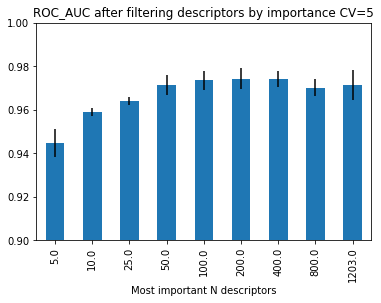

In [193]:
optimiseImportance(clf, X_train_rf, X_test_rf, y_train_rf, y_test_rf)

### Remove labels 
- best performance is with setting N to 100

In [314]:
clf.fit(X_train_t_rf, y_train_t)
X_train_t_rf, X_val_rf, clf = handle_importance(clf, 
                                               X_train_t_rf, 
                                               X_val_rf, 
                                               threshold=-1, 
                                               n=100)

Validation set performance of Random Forest after removing labels
ROC_AUC (TEST): 0.9748310810810811


CLASSIFICATION REPORT:
               precision    recall  f1-score   support

       False       0.86      0.83      0.85        60
        True       0.93      0.95      0.94       148

    accuracy                           0.91       208
   macro avg       0.90      0.89      0.89       208
weighted avg       0.91      0.91      0.91       208



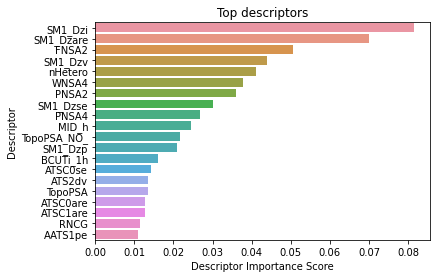

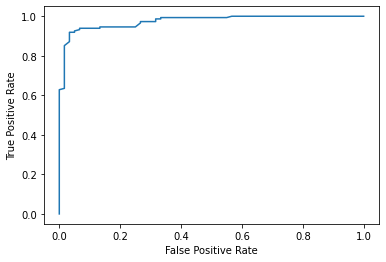

0.9748310810810811

In [315]:
clf.fit(X_train_t_rf, y_train_t)
print("Validation set performance of Random Forest after removing labels")
test_model(clf, y_val, X_val_rf)

In [316]:
clf.fit(X_train_rf, y_train)
X_train_rf, X_test_rf, clf = handle_importance(clf, 
                                               X_train_rf, 
                                               X_test_rf, 
                                               threshold=-1, 
                                               n=100)

In [317]:
X_train_rf

,SM1_Dzi,SM1_Dzare,SM1_Dzv,SM1_Dzse,MID_h,SM1_Dzpe,TopoPSA_NO_,SM1_Dzp,WNSA4,TopoPSA,...,GGI4,SRW08,ETA_epsilon_4,Mare,AATS0are,BCUTd_1h,ATS2m,GGI1,EState_VSA10,EState_VSA1
SMILES,,,,,,,,,,,,,,,,,,,,,
C1=CC(=CC=C1C(=O)O)[N+](=O)[O-],0.917786,1.328525,-1.915303,1.134242,8.840060,1.196068,80.44,-4.847359,-4.732438,80.44,...,0.462222,7.496097,0.659420,1.072235,7.433818,3.139861,2880.144872,3.0,14.908855,10.892616
CCCCCCCCCCCCCCCCO,0.173134,0.285714,-0.398994,0.248495,1.707100,0.258721,20.23,-1.082294,-1.250653,20.23,...,0.080000,6.912743,0.448366,0.927843,5.427647,2.206974,3013.044275,0.5,0.000000,0.000000
C1(C(O1)(F)F)(C(F)(F)F)F,2.295353,2.627178,-3.678952,2.129495,11.989888,2.414500,12.53,-13.071522,-8.671861,12.53,...,0.000000,8.110427,1.445238,1.424000,13.186000,4.155796,4289.380511,5.5,26.342490,18.139708
CC(C)(C=C)O,0.173134,0.285714,-0.398994,0.248495,1.650888,0.258721,20.23,-1.082294,-0.881495,20.23,...,0.000000,6.532334,0.475926,0.950000,5.743750,4.017053,1293.838867,3.0,0.000000,5.601051
C=CCC1=CC2=C(C=C1)OCO2,0.346268,0.571429,-0.797989,0.496990,4.067237,0.517442,18.46,-2.164589,-2.784297,18.46,...,0.408333,7.584265,0.511111,0.981818,6.154545,3.180655,2992.848801,2.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCCCS,-0.086900,-0.024590,0.157579,0.071356,1.681218,0.011628,0.00,0.424138,-0.549242,38.80,...,0.000000,5.105945,0.451111,0.918400,5.290240,2.147554,913.829478,0.5,0.000000,0.000000
CCN(CC)CC,0.225250,0.185668,-0.319325,0.140263,2.045385,0.161184,3.24,-0.518182,-0.342869,3.24,...,0.000000,6.248043,0.445455,0.928545,5.432950,3.029410,1216.020018,1.5,0.000000,0.000000
C1=CC=C(C=C1)C(=O)C2=CC=CC=C2,0.173134,0.285714,-0.398994,0.248495,1.785574,0.258721,17.07,-1.082294,-2.325509,17.07,...,0.382222,7.690286,0.476852,0.966667,5.912500,3.172995,3078.959795,1.5,4.794537,0.000000


## Tuning the hyperparamaters 

In [46]:
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
print(clf.get_params())

Parameters currently in use:

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}


Fitting 5 folds for each of 500 candidates, totalling 2500 fits
{'n_estimators': 294, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 12, 'criterion': 'gini', 'bootstrap': False}
Hyperparamater tuned test performance of Random Forest
ROC_AUC (TEST): 0.9834146341463414


CLASSIFICATION REPORT:
               precision    recall  f1-score   support

       False       0.91      0.86      0.89        50
        True       0.94      0.97      0.96       123

    accuracy                           0.94       173
   macro avg       0.93      0.91      0.92       173
weighted avg       0.94      0.94      0.94       173



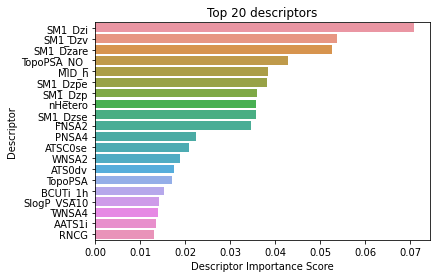

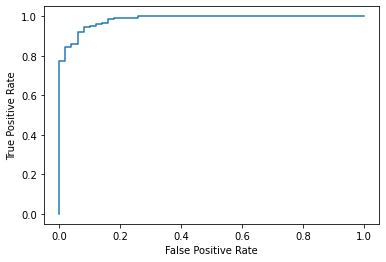

0.9834146341463414

In [49]:
# Use the grid to search for best hyperparameters
# Takes ~ 5 minutes to run 

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 2000, num = 50)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 20, num = 50)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 20, 40, 60, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3, 4, 5, 10]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Criterion 
criterion = ['gini', 'entropy']

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap, 
               'criterion': criterion}

# Random search of parameters, using 5 fold cross validation, 
# search across 500 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=clf, param_distributions = random_grid, n_iter = 500, cv = 5, verbose=1, random_state=SEED, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train_rf, y_train_rf)

# Print best paramaters 
print(rf_random.best_params_)

print("Hyperparamater tuned test performance of Random Forest")
test_model(rf_random.best_estimator_, y_test_rf, X_test_rf)

In [50]:
rf_random.best_estimator_.get_params()

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 12,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 294,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

In [318]:
tuned_rf= RandomForestClassifier(n_estimators=294,
                                 min_samples_split=10,
                                 min_samples_leaf=1,
                                 max_features='sqrt',
                                 max_depth=12,
                                 criterion='gini',
                                 bootstrap=False, 
                                 random_state=SEED)
tuned_rf.fit(X_train_rf, y_train_rf)

RandomForestClassifier(bootstrap=False, max_depth=12, min_samples_split=10,
                       n_estimators=294, random_state=0)

Final tuned validation set performance of Random Forest
ROC_AUC (TEST): 0.9752252252252251


CLASSIFICATION REPORT:
               precision    recall  f1-score   support

       False       0.86      0.83      0.85        60
        True       0.93      0.95      0.94       148

    accuracy                           0.91       208
   macro avg       0.90      0.89      0.89       208
weighted avg       0.91      0.91      0.91       208



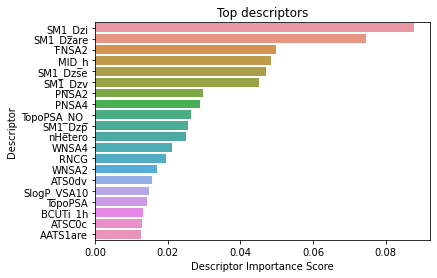

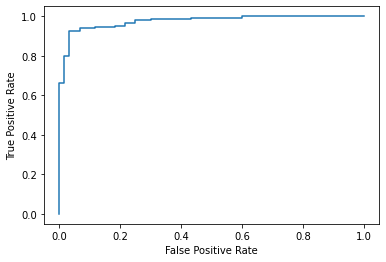

0.9752252252252251

In [321]:
tuned_rf.fit(X_train_t_rf, y_train_t)
print("Final tuned validation set performance of Random Forest")
test_model(tuned_rf, y_val, X_val_rf)

ROC_AUC (TEST): 0.9827642276422764


CLASSIFICATION REPORT:
               precision    recall  f1-score   support

       False       0.90      0.88      0.89        50
        True       0.95      0.96      0.96       123

    accuracy                           0.94       173
   macro avg       0.92      0.92      0.92       173
weighted avg       0.94      0.94      0.94       173



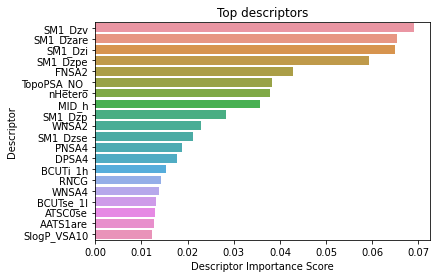

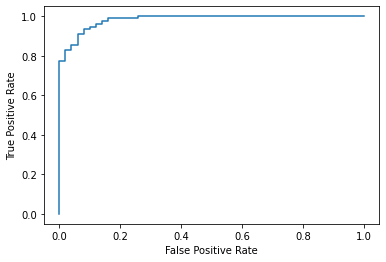

0.9827642276422764

In [322]:
tuned_rf.fit(X_train_rf, y_train_rf)
test_model(tuned_rf, y_test_rf, X_test_rf)

## Extract correlation scores for important features

Extracted correlation scores for most important 100 features for random forest
Printing heatmap for most important 15 features


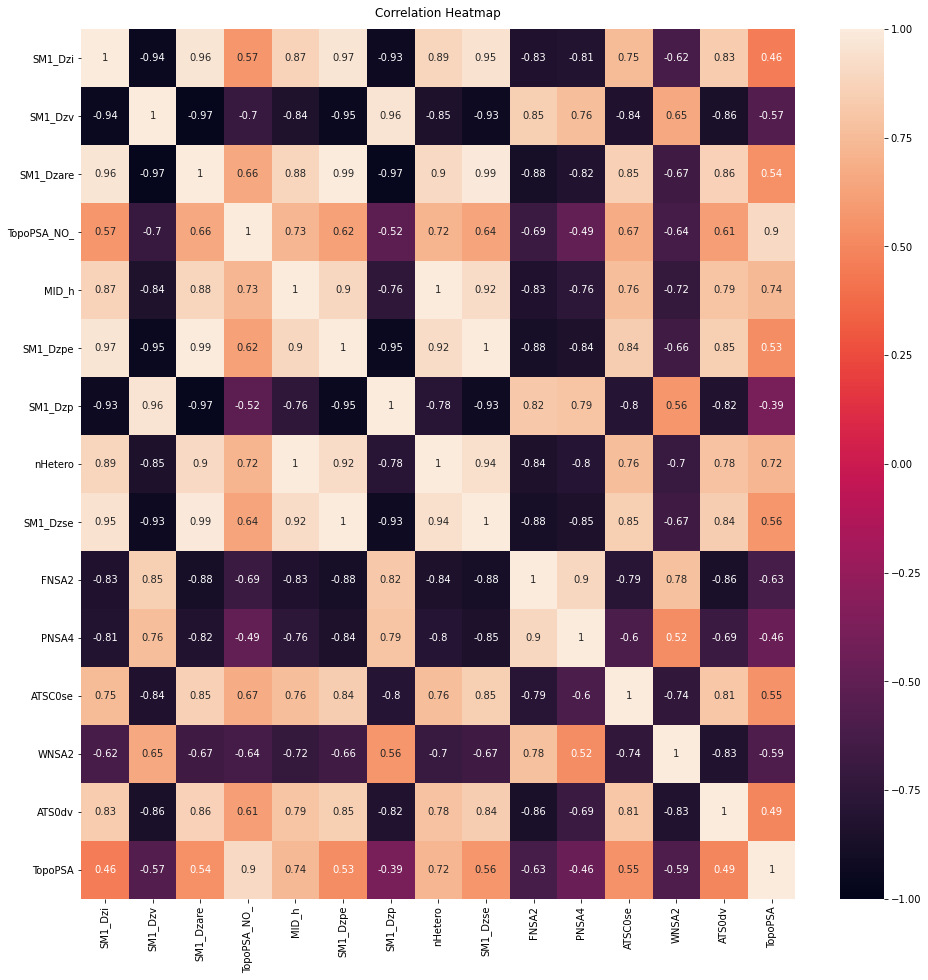

In [78]:
corrs_important_features(tuned_rf, X_test_rf, "random forest", 100, heatmap=15)

## Save dataframe used in RF to CSV
- i.e. dataframe with all columns with *any* missing values removed

In [57]:
rf_csv = df.loc[:,X_train_rf.columns]
rf_csv.to_csv('data/random-forest-df.csv')  
rf_csv

,FNSA2,TopoPSA_NO_,SM1_Dzse,SM1_Dzare,SM1_Dzi,ATSC0se,PNSA4,GRAV,WNSA4,SM1_Dzm,...,Mor09se,IC0,ATSC1dv,AATS0i,SMR,VSA_EState3,Mor31,Xpc_5dv,piPC2,AATSC1pe
SMILES,,,,,,,,,,,,,,,,,,,,,
C1=CC=C2C(=C1)C(=O)C(C2=O)(O)O,-0.915439,74.60,0.993979,1.142857,0.692537,3.054191,-16.054904,2344.195126,-5.349824,0.997062,...,-0.413947,1.509028,5.393352,157.497908,42.2716,18.218704,0.191285,1.169741,3.597312,-0.037694
C(=C(F)F)(C(F)(F)F)C(F)(F)F,-1.298106,0.00,2.508000,3.121951,2.829626,4.193376,-31.248175,3079.984723,-9.026518,2.942312,...,-2.478051,0.918296,-4.000000,244.634092,21.3520,0.000000,0.254839,0.457475,3.135494,-0.082622
C1=C(C=C(C(=C1[N+](=O)[O-])O)[N+](=O)[O-])[N+](=O)[O-],-1.567908,149.65,2.160253,2.557003,1.887688,3.687211,-29.743377,3420.554144,-10.720464,2.172360,...,-0.768105,1.896820,4.315789,170.915699,48.0700,40.214036,-0.326020,0.779968,3.725693,0.050768
CN1C(=O)CN=C(C2=C1C=CC(=C2)Cl)C3=CC=CC=C3,-0.627113,32.67,0.738805,0.773658,0.755294,2.057077,-9.128078,3902.682223,-4.384569,1.195451,...,-0.683537,1.586645,37.083245,157.840303,81.8100,0.634380,0.556803,1.712699,4.025352,0.002859
C(C(C(F)(F)F)(F)Cl)(F)Cl,-1.026223,0.00,1.987068,2.184435,2.031838,3.734135,-26.660661,2814.087423,-7.618910,3.161314,...,-1.057832,1.789929,5.087440,219.944489,26.4960,-4.491512,0.235841,0.729616,2.772589,-0.053157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCCCC(=O)OCC,-0.214952,26.30,0.496990,0.571429,0.346268,1.975926,-3.294040,1059.468170,-1.161034,0.498531,...,1.257362,1.264673,28.982987,167.274356,36.1580,0.000000,0.663010,0.100592,2.397895,0.004651
C=CCSS(=O)CC=C,-0.272162,17.07,0.391207,0.236534,-0.000667,1.148345,-5.106279,1564.446393,-1.820266,1.499983,...,0.145466,1.577977,-8.325023,158.423871,45.8614,0.000000,0.337999,0.530330,2.564949,0.001204
CCCC(=O)OCC(C)C,-0.222321,26.30,0.496990,0.571429,0.346268,2.012234,-3.194120,1218.316536,-1.193149,0.498531,...,1.344064,1.238901,30.994083,167.074610,40.7050,0.000000,0.830591,0.178519,2.564949,0.004367


# XgBoost

https://practicaldatascience.co.uk/machine-learning/how-to-create-a-classification-model-using-xgboost

In [324]:
# for readibility 
y_train_xgb = y_train
y_test_xgb = y_test
X_train_xgb = X_train
X_test_xgb = X_test

## Create model

In [327]:
xgb = XGBClassifier(random_state=SEED)
xgb.fit(X_train_xgb, y_train_xgb)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=0, ...)

Baseline test performance of XGBoost
ROC_AUC (TEST): 0.9754471544715447


CLASSIFICATION REPORT:
               precision    recall  f1-score   support

       False       0.90      0.90      0.90        50
        True       0.96      0.96      0.96       123

    accuracy                           0.94       173
   macro avg       0.93      0.93      0.93       173
weighted avg       0.94      0.94      0.94       173



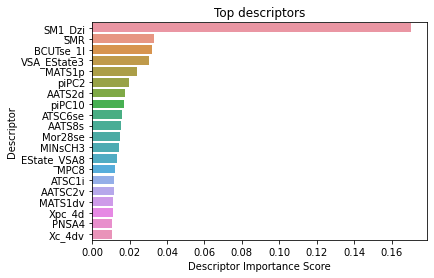

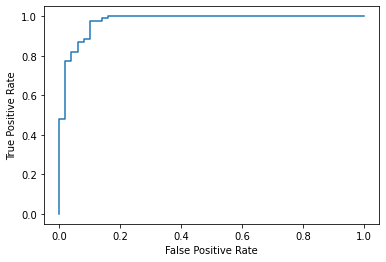

0.9754471544715447

In [368]:
# Baseline results
print("Baseline test performance of XGBoost")
test_model(xgb, y_test_xgb, X_test_xgb)

## Handle NaNs

Cross validated missing values experiment with k=5


,Name,Average ROC_AUC,Standard Deviation
0,0.0,0.970720,0.004632
1,0.1,0.969555,0.003055
2,0.2,0.969100,0.001470
3,0.3,0.968945,0.002606
4,0.4,0.966706,0.003670
5,0.5,0.966507,0.001691
6,0.6,0.968182,0.002727
7,0.7,0.967666,0.003408
8,0.8,0.968379,0.003460
9,0.9,0.968379,0.003460


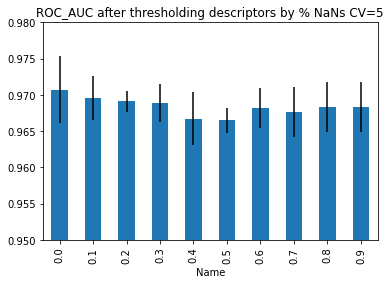

In [369]:
# choose optimal threshold for removing columns with NaNs
optimiseNaNs(xgb, X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb, option=2)

Choose to remove any columns with NaNs

In [325]:
X_train_xgb, X_test_xgb = handleNaNs(X_train_xgb.copy(), X_test_xgb.copy(), option=1, thresh=0)
X_train_t_xgb, X_val_xgb = handleNaNs(X_train_t.copy(), X_val.copy(), option=1, thresh=0)

Validation performance of XGBoost after removing NaNs
ROC_AUC (TEST): 0.9791666666666666


CLASSIFICATION REPORT:
               precision    recall  f1-score   support

       False       0.91      0.88      0.90        60
        True       0.95      0.97      0.96       148

    accuracy                           0.94       208
   macro avg       0.93      0.92      0.93       208
weighted avg       0.94      0.94      0.94       208



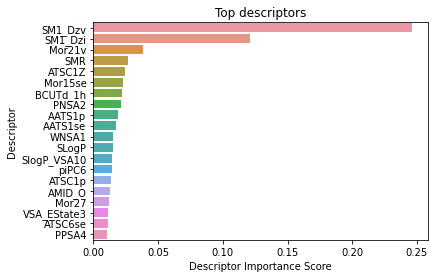

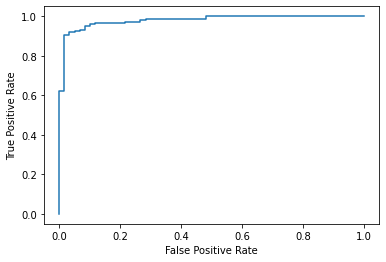

0.9791666666666666

In [328]:
xgb.fit(X_train_t_xgb, y_train_t)
print("Validation performance of XGBoost after removing NaNs")
test_model(xgb, y_val, X_val_xgb)

## Importance Experiment XGB

Cross validated importance experiment with k=5
N:5
N:10
N:25
N:50
N:100
N:200
N:400
N:800
N:1203


,Most important N descriptors,Average ROC_AUC,Standard Deviation
0,5.0,0.957280,0.006009
1,10.0,0.961766,0.010015
2,25.0,0.975956,0.005756
3,50.0,0.979069,0.002700
4,100.0,0.977904,0.004391
5,200.0,0.974487,0.002900
6,400.0,0.972098,0.003250
7,800.0,0.969805,0.004610
8,1203.0,0.974384,0.003948


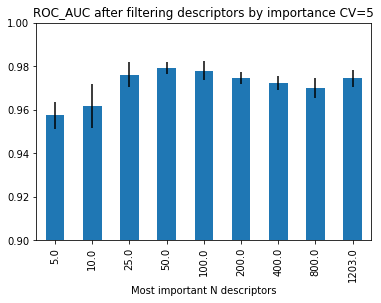

In [372]:
optimiseImportance(xgb, X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb)

Validation set performance after filtering by importance XGBoost
ROC_AUC (TEST): 0.9819819819819819


CLASSIFICATION REPORT:
               precision    recall  f1-score   support

       False       0.90      0.88      0.89        60
        True       0.95      0.96      0.96       148

    accuracy                           0.94       208
   macro avg       0.93      0.92      0.92       208
weighted avg       0.94      0.94      0.94       208



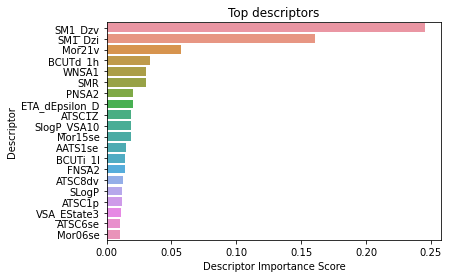

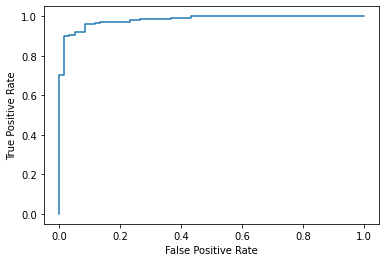

0.9819819819819819

In [333]:
X_train_xgb, X_test_xgb, xgb = handle_importance(xgb, 
                                                X_train_xgb, 
                                                X_test_xgb, 
                                                threshold=-1, 
                                                n=100)

X_train_t_xgb, X_val_xgb, xgb = handle_importance(xgb, 
                                                X_train_t_xgb, 
                                                X_val_xgb, 
                                                threshold=-1, 
                                                n=100)
xgb.fit(X_train_t_xgb, y_train_t)

# Filted importance results
print("Validation set performance after filtering by importance XGBoost")
test_model(xgb, y_val, X_val_xgb)

In [61]:
X_train_xgb

,SM1_Dzi,Xpc_4d,nHBDon,Mor28se,piPC10,BCUTse_1l,FCSP3,TopoPSA,Mor21v,ATSC1v,...,SIC3,PEOE_VSA9,Xc_3d,ATSC3c,Mor26,Mor13,Mor13p,IC0,MID_N,BCUTc_1l
SMILES,,,,,,,,,,,,,,,,,,,,,
C1=CC(=CC=C1C(=O)O)[N+](=O)[O-],0.917786,2.080880,1,0.172126,0.000000,2.437846,0.0,80.44,-0.195907,50.168861,...,1.000000,10.486763,1.000000,0.107048,-0.297601,-0.107249,-0.298644,1.777985,2.012880,-0.387593
CCCCCCCCCCCCCCCCO,0.173134,0.000000,1,-0.361095,2.079442,2.550132,1.0,20.23,-0.659213,-73.692870,...,0.467623,0.000000,0.000000,0.015420,1.057518,1.499624,0.576315,1.025881,0.000000,-0.223154
C1(C(O1)(F)F)(C(F)(F)F)F,2.295353,5.041815,0,-0.030493,0.000000,2.589681,1.0,12.53,-0.003930,-29.059914,...,0.796658,0.000000,2.774049,-0.076539,-0.065844,-0.592651,-0.292314,1.295462,0.000000,-0.293189
CC(C)(C=C)O,0.173134,1.060660,1,-0.154986,0.000000,2.498174,0.6,20.23,-0.063345,-64.083880,...,0.695160,5.601051,1.560660,-0.069567,0.294281,0.299103,-0.071999,1.198192,0.000000,-0.257264
C=CCC1=CC2=C(C=C1)OCO2,0.346268,1.327709,0,-0.118756,3.548180,2.437101,0.2,18.46,-0.120608,-32.245275,...,0.938843,0.000000,0.537457,0.083168,0.064225,-0.421997,-0.463456,1.348588,0.000000,-0.486864
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCCCS,-0.086900,0.000000,1,-0.200455,0.000000,2.575514,1.0,38.80,-0.162785,-115.229220,...,0.816480,0.000000,0.000000,0.003194,0.278638,0.502512,0.217970,1.158939,0.000000,-0.173142
CCN(CC)CC,0.225250,0.612372,0,-0.212719,0.000000,2.608011,1.0,3.24,-0.318129,-213.508320,...,0.454182,0.000000,0.204124,-0.048836,0.298575,0.981494,0.275455,1.090653,2.045385,-0.374281
C1=CC=C(C=C1)C(=O)C2=CC=CC=C2,0.173134,1.541519,0,-0.082979,5.731874,2.432022,0.0,17.07,-0.330898,42.202219,...,0.713649,0.000000,0.525783,0.045485,-0.151671,0.443743,-0.291929,1.196421,0.000000,-0.377925


## Tuning paramaters 

In [354]:
params = {
    'learning_rate': (0.01, 1.0),
    'n_estimators': (100, 1000),
    'max_depth': (3,10),
#    'subsample': (0.7, 1.0),  # Change for big datasets
    'colsample_bytree': (0.7, 1.0),  # Change for datasets with lots of features
    'gamma': (0, 5), 
    'scale_pos_weight': (1, 2.5)
    }

def xgboost_hyper_param(learning_rate,
                        n_estimators,
                        max_depth,
                        colsample_bytree,
                        gamma, 
                        scale_pos_weight):

    max_depth = int(max_depth)
    n_estimators = int(n_estimators)

    xgb_temp = XGBClassifier(
        max_depth=max_depth,
        colsample_bytree=colsample_bytree,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        gamma=gamma,
        scale_pos_weight=scale_pos_weight,
        seed=SEED)
    
    # calculate CV=5 K fold ROC_AUC accuracy for each model 

    return np.array(cross_val_score(xgb_temp, X_train_t_xgb, y_train_t, cv=3, scoring='roc_auc')).mean()

optimizer = BayesianOptimization(
            f=xgboost_hyper_param,
            pbounds=params,
            random_state=SEED)

optimizer.maximize(init_points=5, n_iter=50)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | n_esti... | scale_... |
-------------------------------------------------------------------------------------------------
| 1         | 0.9675    | 0.8646    | 3.576     | 0.6067    | 6.814     | 481.3     | 1.969     |
| 2         | 0.9606    | 0.8313    | 4.459     | 0.964     | 5.684     | 812.6     | 1.793     |
| 3         | 0.9647    | 0.8704    | 4.628     | 0.08033   | 3.61      | 118.2     | 2.249     |
| 4         | 0.9472    | 0.9334    | 4.35      | 0.9788    | 8.594     | 515.3     | 2.171     |
| 5         | 0.9689    | 0.7355    | 3.2       | 0.1519    | 9.613     | 569.7     | 1.622     |
| 6         | 0.9688    | 0.9624    | 3.005     | 0.5395    | 9.982     | 570.9     | 2.448     |
| 7         | 0.9569    | 0.7233    | 3.645     | 0.9298    | 6.235     | 456.0     | 1.172     |
| 8         | 0.9673    | 0.8344    | 2.112     | 0.1516    | 3.19      | 591.7     | 1.477     |
| 9         | 0.9621

| 51        | 0.9704    | 0.9567    | 0.0       | 0.8125    | 6.106     | 136.4     | 2.5       |
| 52        | 0.9721    | 0.8502    | 0.3637    | 0.2227    | 9.6       | 136.7     | 1.866     |
| 53        | 0.9552    | 0.8957    | 3.835     | 0.9222    | 8.485     | 138.1     | 2.295     |
| 54        | 0.9689    | 0.7292    | 0.1973    | 0.447     | 8.91      | 133.5     | 1.047     |
| 55        | 0.9647    | 0.7286    | 3.832     | 0.3725    | 8.514     | 999.7     | 1.016     |


{'colsample_bytree': 0.8382720051634408, 'gamma': 0.0761002923503068, 'learning_rate': 0.20218582149285758, 'max_depth': 8, 'n_estimators': 149, 'scale_pos_weight': 1.9451342292110263}
ROC_AUC (TEST): 0.9809684684684684


CLASSIFICATION REPORT:
               precision    recall  f1-score   support

       False       0.91      0.87      0.89        60
        True       0.95      0.97      0.96       148

    accuracy                           0.94       208
   macro avg       0.93      0.92      0.92       208
weighted avg       0.94      0.94      0.94       208



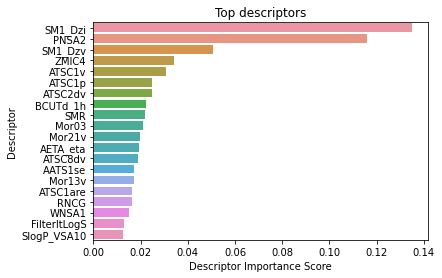

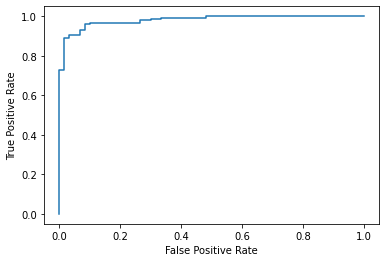

0.9809684684684684

In [356]:
params_tuned_xgb = optimizer.max['params']
params_tuned_xgb['max_depth'] = int(params_tuned_xgb['max_depth'])
params_tuned_xgb['n_estimators'] = int(params_tuned_xgb['n_estimators'])
print(params_tuned_xgb)

tuned_xgb = XGBClassifier(**params_tuned_xgb, seed=SEED)
tuned_xgb.fit(X_train_t_xgb, y_train_t)
test_model(tuned_xgb, y_val, X_val_xgb)

### Final tuned paramaters


Final tuned validation set performance for XGB
ROC_AUC (TEST): 0.9809684684684684


CLASSIFICATION REPORT:
               precision    recall  f1-score   support

       False       0.91      0.87      0.89        60
        True       0.95      0.97      0.96       148

    accuracy                           0.94       208
   macro avg       0.93      0.92      0.92       208
weighted avg       0.94      0.94      0.94       208



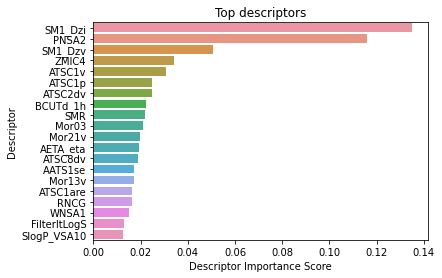

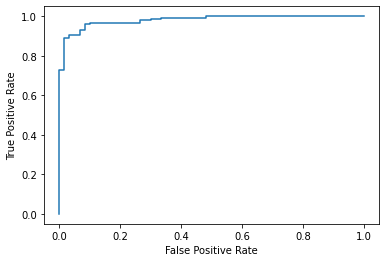

0.9809684684684684

In [357]:
params = {'colsample_bytree': 0.8382720051634408, 'gamma': 0.0761002923503068, 'learning_rate': 0.20218582149285758, 'max_depth': 8, 'n_estimators': 149, 'scale_pos_weight': 1.9451342292110263}
tuned_xgb = XGBClassifier(**params,
                          seed=SEED,  
                          n_jobs = -1)

print("Final tuned validation set performance for XGB")
tuned_xgb.fit(X_train_t_xgb, y_train_t)
test_model(tuned_xgb, y_val, X_val_xgb)

ROC_AUC (TEST): 0.9757723577235772


CLASSIFICATION REPORT:
               precision    recall  f1-score   support

       False       0.92      0.90      0.91        50
        True       0.96      0.97      0.96       123

    accuracy                           0.95       173
   macro avg       0.94      0.93      0.94       173
weighted avg       0.95      0.95      0.95       173



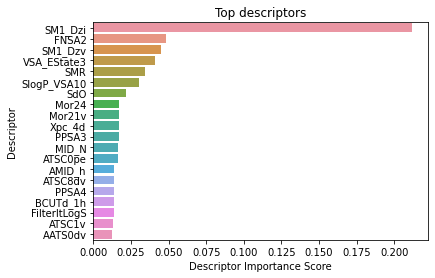

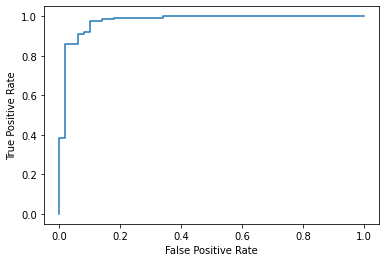

0.9757723577235772

In [358]:
tuned_xgb.fit(X_train_xgb, y_train_xgb)
test_model(tuned_xgb, y_test_xgb, X_test_xgb)

## Extract correlation for 'important' features

Extracted correlation scores for most important 100 features for xgb
Printing heatmap for most important 15 features


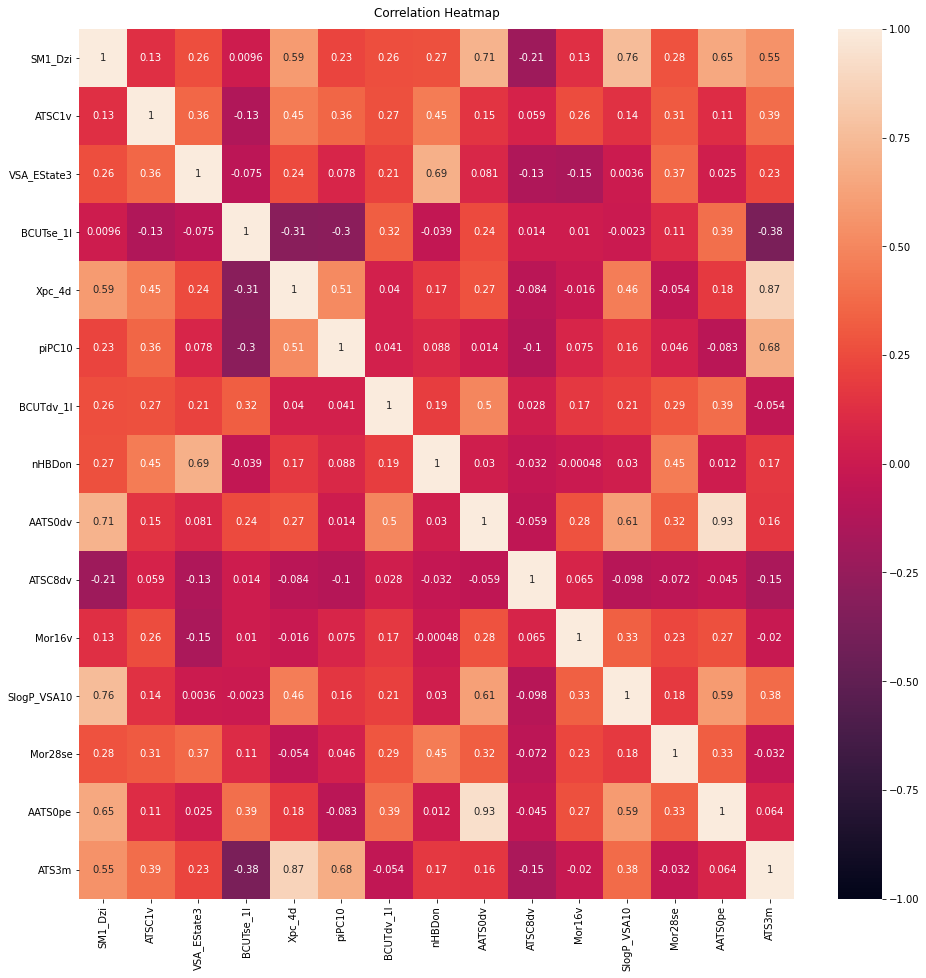

In [65]:
corrs_important_features(tuned_xgb, X_test_xgb, "xgb", 100, 15)

## Save dataframe used in XGB to CSV

In [105]:
rf_csv = df.loc[:,X_train_xgb.columns]
rf_csv.to_csv('data/xgb-df.csv')  
rf_csv

,SM1_Dzi,Xpc_4d,nHBDon,Mor28se,piPC10,BCUTse_1l,FCSP3,TopoPSA,Mor21v,ATSC1v,...,SIC3,PEOE_VSA9,Xc_3d,ATSC3c,Mor26,Mor13,Mor13p,IC0,MID_N,BCUTc_1l
SMILES,,,,,,,,,,,,,,,,,,,,,
C1=CC=C2C(=C1)C(=O)C(C2=O)(O)O,0.692537,4.199803,2,0.409774,4.123094,2.433499,0.111111,74.60,-0.278505,141.691079,...,0.776981,0.000000,1.516182,0.232008,-0.241416,-0.985484,-0.636023,1.509028,0.000000,-0.369000
C(=C(F)F)(C(F)(F)F)C(F)(F)F,2.829626,2.866025,0,-0.115333,0.000000,2.492362,0.500000,0.00,0.119063,-23.514339,...,0.546490,0.000000,3.148717,-1.004040,0.040390,-0.549232,-0.331272,0.918296,0.000000,-0.231510
C1=C(C=C(C(=C1[N+](=O)[O-])O)[N+](=O)[O-])[N+](=O)[O-],1.887688,3.478647,1,0.176266,0.000000,2.438368,0.000000,149.65,-0.253994,73.329816,...,0.857395,26.902667,1.631282,-0.118944,-0.511254,-0.088066,-0.329633,1.896820,6.048072,-0.387267
CN1C(=O)CN=C(C2=C1C=CC(=C2)Cl)C3=CC=CC=C3,0.755294,3.312035,0,0.184432,7.092158,2.428710,0.125000,32.67,-0.518595,-14.411420,...,0.930858,11.399071,1.291742,0.148985,0.104435,0.195934,-0.534217,1.586645,4.191332,-0.399672
C(C(C(F)(F)F)(F)Cl)(F)Cl,2.031838,5.425426,0,-0.155282,0.000000,2.582453,1.000000,0.00,-0.023427,-18.751572,...,0.875048,0.000000,2.366025,-0.010165,0.106500,0.032360,0.084802,1.789929,0.000000,-0.251843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCCCC(=O)OCC,0.346268,0.408248,0,-0.436179,0.000000,2.565122,0.857143,26.30,-0.315417,-149.595000,...,0.831705,6.606882,0.288675,-0.035943,0.324668,0.797557,0.248178,1.264673,0.000000,-0.496353
C=CCSS(=O)CC=C,-0.000667,0.408248,0,-0.369831,0.000000,2.510636,0.333333,61.58,-0.208334,21.460314,...,0.851321,15.584436,0.288675,0.003020,0.402102,0.063143,-0.087691,1.577977,0.000000,-0.360758
CCCC(=O)OCC(C)C,0.346268,0.696923,0,-0.479310,0.000000,2.560364,0.875000,26.30,-0.342441,-150.640033,...,0.768723,6.606882,0.696923,0.037507,0.480583,1.342821,0.383464,1.238901,0.000000,-0.495706


# Compare descriptors used by both models 

In [395]:
len(set(X_train_rf.columns) - set(X_train_xgb.columns))

76

In [396]:
len(set(X_train_xgb.columns) - set(X_train_rf.columns))

76

# Keras

https://www.pluralsight.com/guides/classification-keras

In [199]:
!pip install keras
!pip install scikeras

import tensorflow as tf
import keras_tuner as kt
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical 
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


# for readibility 
y_train_nn = y_train.copy()
y_test_nn = y_test.copy()
X_train_nn = X_train.copy()
X_test_nn = X_test.copy()

tf.random.set_seed(SEED)

In [200]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 692 entries, C1=CC(=CC=C1C(=O)O)[N+](=O)[O-] to CC(C)N
Columns: 1826 entries, ABC to mZagreb2
dtypes: float64(1487), int64(339)
memory usage: 9.6+ MB


## Preprocessing

### Handle NaNs 
- You can't have missing values in a Neural Network, so we choose to remove all columns with them (for now)

In [257]:
X_train_nn, X_test_nn = handleNaNs(X_train.copy(), X_test.copy(), option=1)

## Prepare a validation set
- Stratified 

In [359]:
X_train_t_nn, X_val_nn, y_train_t_nn, y_val_nn = X_train_t, X_val, y_train_t, y_val

### Standardization 

Standardization is an effective data preparation scheme for tabular data when building neural network models. This is where the data is rescaled such that the mean value for each attribute is 0, and the standard deviation is 1. This preserves Gaussian and Gaussian-like distributions while normalizing the central tendencies for each attribute.

https://machinelearningmastery.com/binary-classification-tutorial-with-the-keras-deep-learning-library/

- not necessary for tree based algorithms because they are fairly insensitive to the scale of features "The decision tree splits a node on a feature that increases the homogeneity of the node. This split on a feature is not influenced by other features. Hence, there is virtually no effect of the remaining features on the split. This is what makes them invariant to the scale of the features." https://www.atoti.io/articles/when-to-perform-a-feature-scaling/#:~:text=In%20Neural%20Networks%20algorithm%20that,an%20essential%20pre%2Dprocessing%20step.

- Note: The StandardScaler is only fit using the train_features to be sure the model is not peeking at the validation or test sets.

In [259]:
scaler = StandardScaler()
X_train_t_nn = scaler.fit_transform(X_train_t_nn) 
X_val_nn = scaler.transform(X_val_nn) 

scaler2 = StandardScaler()
X_train_nn = scaler2.fit_transform(X_train_nn) 
X_test_nn = scaler2.transform(X_test_nn) 

### Encode class values as integers

Use adam optimizer so we don't have to specify learning rate, as is the case with gradient descent, and optimise for it

In [260]:
encoder = LabelEncoder()
encoder.fit(y_train_nn)
y_train_nn = encoder.transform(y_train_nn)
y_train_t_nn = encoder.transform(y_train_t_nn)
y_test_nn = encoder.transform(y_test_nn)
y_val_nn = encoder.transform(y_val_nn)

## Metrics

In [248]:
METRICS = [
  keras.metrics.TruePositives(name='tp'),
  keras.metrics.FalsePositives(name='fp'),
  keras.metrics.TrueNegatives(name='tn'),
  keras.metrics.FalseNegatives(name='fn'), 
  keras.metrics.Precision(name='precision'),
  keras.metrics.Recall(name='recall'),
  keras.metrics.AUC(name='auc', curve='ROC'),
]

## Test model - Keras

In [231]:
def test_model_keras(model, history, X_val_nn, y_val_nn, X_train_nn, y_train_nn): 
    # Plot training and validation auc 

    plt.plot(history.history['auc'])
    plt.plot(history.history['val_auc'])
    plt.title('model roc_auc')
    plt.ylabel('ROC_AUC')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()

    # Plot training and validation ROC curve

    y_pred_keras = model.predict(X_val_nn).ravel()
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_val_nn, y_pred_keras)
    auc_v_keras = metrics.roc_auc_score(y_val_nn, y_pred_keras)

    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_keras, tpr_keras)

    y_pred_t_keras = model.predict(X_train_nn).ravel()
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_train_nn, y_pred_t_keras)
    auc_t_keras = metrics.roc_auc_score(y_train_nn, y_pred_t_keras)

    plt.plot(fpr_keras, tpr_keras)

    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(['', 'Validation (area = {:.3f})'.format(auc_v_keras), 'Training (area = {:.3f})'.format(auc_t_keras)], loc='best')
    plt.show()
    plt.show()


## Baseline Single Layer model
- Overfitting quite a bit, you can see it when you compare the validation set auc and the auc for the training set 

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 1204)              1449616   
                                                                 
 dense_13 (Dense)            (None, 1)                 1205      
                                                                 
Total params: 1,450,821
Trainable params: 1,450,821
Non-trainable params: 0
_________________________________________________________________


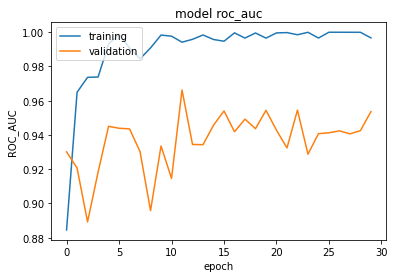

18/18 [==============================] - 0s 3ms/step


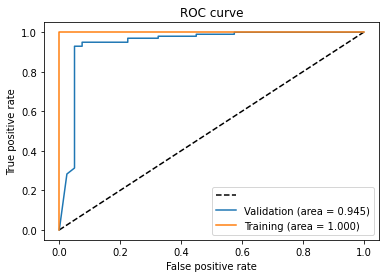

In [249]:
model = keras.Sequential()
model.add(keras.layers.Dense(X_train_nn.shape[-1]+1, activation="relu", input_shape=(X_train_nn.shape[-1],)))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

history = model.fit(X_train_t_nn, 
                      y_train_t_nn, 
                      epochs=30, 
                      validation_data=(X_val_nn, y_val_nn), 
                      verbose=0)

test_model_keras(model, history, X_val_nn, y_val_nn, X_train_t_nn, y_train_t_nn)

## Tuning Multi Layer model

In [31]:
def model_builder(hp):

    model = keras.Sequential()
    model.add(Dense(len(X_train_t_nn[0]), input_shape=(len(X_train_t_nn[0]),), activation='relu'))

    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 2-length of layers
    hp_units = hp.Int('unit_1', min_value=2, max_value=2000, step=10)
    model.add(keras.layers.Dense(units=hp_units, activation='relu'))
    
    # dropout layer reduces overfitting
    hp_units = hp.Float('dropout_1', min_value=0.0, max_value=0.5, default=0.25, step=0.05)
    model.add(keras.layers.Dropout(hp_units))
    
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 2-length of layers
    hp_units = hp.Int('unit_2', min_value=2, max_value=2000, step=10)
    model.add(keras.layers.Dense(units=hp_units, activation='relu'))
    
    model.add(Dense(1, activation='sigmoid'))
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='binary_crossentropy',
                  metrics=METRICS)

    return model

### Instantiate the tuner and perform hypertuning

https://www.tensorflow.org/tutorials/keras/keras_tuner The Hyperband tuning algorithm uses adaptive resource allocation and early-stopping to quickly converge on a high-performing model. This is done using a sports championship style bracket. The algorithm trains a large number of models for a few epochs and carries forward only the top-performing half of models to the next round. Hyperband determines the number of models to train in a bracket by computing 1 + logfactor(max_epochs) and rounding it up to the nearest integer. Create a callback to stop training early after reaching a certain value for the validation loss.



To instantiate the Hyperband tuner, you must specify the hypermodel, the objective to optimize and the maximum number of epochs to train (max_epochs).

In [32]:
tuner = kt.Hyperband(model_builder,
                     objective=kt.Objective("val_auc", direction="max"),
                     max_epochs=10,
                     factor=3,
                     seed=SEED, 
                     directory="results_dir",
                     project_name="odor",
                     overwrite=True,)

tuner.search(X_train_t_nn, 
             y_train_t_nn, 
             epochs=30,
             validation_data=(X_val_nn, y_val_nn),
             callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss")])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 30 Complete [00h 00m 03s]
val_auc: 0.9617424011230469

Best val_auc So Far: 0.9674242734909058
Total elapsed time: 00h 01m 13s
INFO:tensorflow:Oracle triggered exit


In [33]:
print(f"""
The hyperparameter search is complete. \n The optimal number of units in the first densely-connected
layer is {best_hps.get('unit_1')} \n The optimal number of units in the second densely-connected
layer is {best_hps.get('unit_2')} \n The optimal number of dropouts in the first densely-connected
layer is {best_hps.get('dropout_1')}.\n The optimal learning 
rate is  {best_hps.get('learning_rate')}
""")


The hyperparameter search is complete. 
 The optimal number of units in the first densely-connected
layer is 1862 
 The optimal number of units in the second densely-connected
layer is 1002 
 The optimal number of dropouts in the first densely-connected
layer is 0.2.
 The optimal learning 
rate is  0.001



In [44]:
model3 = tuner.hypermodel.build(best_hps)
model3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 1203)              1448412   
                                                                 
 dense_17 (Dense)            (None, 1862)              2241848   
                                                                 
 dropout_4 (Dropout)         (None, 1862)              0         
                                                                 
 dense_18 (Dense)            (None, 1002)              1866726   
                                                                 
 dense_19 (Dense)            (None, 1)                 1003      
                                                                 
Total params: 5,557,989
Trainable params: 5,557,989
Non-trainable params: 0
_________________________________________________________________


Epoch 1/30
18/18 [==============================] - 2s 60ms/step - loss: 0.7348 - tp: 424.0000 - fp: 53.0000 - tn: 147.0000 - fn: 68.0000 - precision: 0.8889 - recall: 0.8618 - auc: 0.8555 - val_loss: 0.2203 - val_tp: 92.0000 - val_fp: 6.0000 - val_tn: 34.0000 - val_fn: 7.0000 - val_precision: 0.9388 - val_recall: 0.9293 - val_auc: 0.9653
Epoch 2/30
18/18 [==============================] - 1s 43ms/step - loss: 0.2106 - tp: 370.0000 - fp: 30.0000 - tn: 130.0000 - fn: 23.0000 - precision: 0.9250 - recall: 0.9415 - auc: 0.9673 - val_loss: 0.2803 - val_tp: 95.0000 - val_fp: 8.0000 - val_tn: 32.0000 - val_fn: 4.0000 - val_precision: 0.9223 - val_recall: 0.9596 - val_auc: 0.9559
Epoch 3/30
18/18 [==============================] - 1s 45ms/step - loss: 0.1387 - tp: 382.0000 - fp: 21.0000 - tn: 139.0000 - fn: 11.0000 - precision: 0.9479 - recall: 0.9720 - auc: 0.9860 - val_loss: 0.3215 - val_tp: 93.0000 - val_fp: 8.0000 - val_tn: 32.0000 - val_fn: 6.0000 - val_precision: 0.9208 - val_recall: 0.

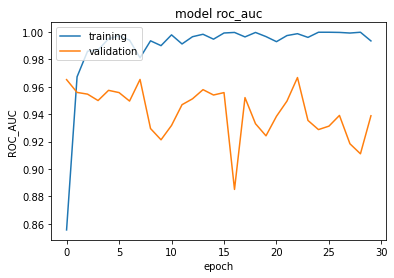

18/18 [==============================] - 0s 5ms/step


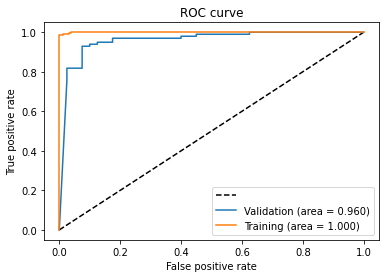

In [45]:
# Build the model with the optimal hyperparameters 
history = model3.fit( X_train_t_nn, 
                      y_train_t_nn, 
                      epochs=30, 
                      validation_data=(X_val_nn, y_val_nn), 
                      verbose=1)

test_model_keras(model3, history, X_val_nn, y_val_nn, X_train_t_nn, y_train_t_nn)

## Feature selection 

Using the set of the top 100 descriptors from RF and XGB, filter the dataset by these descriptors, and then measure validation accuracy

In [56]:
def model_builder_2(hp):

    model = keras.Sequential()
    model.add(Dense(len(X_train_t_nn_temp[0]), input_shape=(len(X_train_t_nn_temp[0]),), activation='relu'))
    
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 2-length of layers
    hp_units = hp.Int('unit_1', min_value=2, max_value=2000, step=10)
    model.add(keras.layers.Dense(units=hp_units, activation='relu'))
    
    # dropout layer reduces overfitting
    hp_units = hp.Float('dropout_1', min_value=0.0, max_value=0.5, default=0.25, step=0.05)
    model.add(keras.layers.Dropout(hp_units))
    
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 2-length of layers
    hp_units = hp.Int('unit_2', min_value=2, max_value=2000, step=10)
    model.add(keras.layers.Dense(units=hp_units, activation='relu'))
    
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 2-length of layers
    hp_units = hp.Int('unit_3', min_value=2, max_value=2000, step=10)
    model.add(keras.layers.Dense(units=hp_units, activation='relu'))
    
    model.add(Dense(1, activation='sigmoid'))
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 5e-2, 1e-3, 5e-3, 1e-4, 5e-4])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='binary_crossentropy',
                  metrics=METRICS)

    return model

### Use different algorithms for feature ranking

In [654]:
import sklearn.feature_selection as fs
from sklearn.svm import LinearSVC

algos = ['rf', 'l1', 'f_classif', 'mutual_info_classif', 'random']
ks = [1, 5, 15, 50, 100, 400, 800, 1203]

accuracy_2 = pd.DataFrame(index = ks, columns = algos)

for algo in algos:
  print(algo)
  
  for k in ks:
        print(k)

        X_train_t_nn_temp = X_train_t_nn.copy()
        X_val_nn_temp = X_val_nn.copy()
        
        if algo == 'random':
            ranking['random'] = list(range(len(X_train_t_nn)))
            random.shuffle(ranking['random'])
            top_n = ranking[algo][0:k]
            X_train_t_nn_temp = (X_train_t_nn)[:,top_n]
            X_val_nn_temp = (X_val_nn)[:,top_n]
        else:
            if algo == 'f_classif': 
                bk = fs.SelectKBest(fs.f_classif, k=k)
                bk.fit(X_train_t_nn, y_train_t_nn)
            elif algo == "mutual_info_classif":
                bk = fs.SelectKBest(fs.mutual_info_classif, k=k)
                bk.fit(X_train_t_nn, y_train_t_nn)
            elif algo == 'rf':
                tuned_rf.fit(X_train_t_nn_temp, y_train_t_nn)
                bk = fs.SelectFromModel(tuned_rf, prefit=True, max_features=k)
            elif algo == 'l1': 
                lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X_train_t_nn, y_train_t_nn)
                bk = fs.SelectFromModel(lsvc, prefit=True)

            X_train_t_nn_temp = bk.transform(X_train_t_nn)
            X_val_nn_temp = bk.transform(X_val_nn_temp)
        
        tuner = kt.Hyperband(model_builder_2,
                             objective=kt.Objective("val_auc", direction="max"),
                             max_epochs=10,
                             factor=3,
                             seed=SEED, 
                             directory="results_dir",
                             project_name="odor",
                             overwrite=True,)

        tuner.search(X_train_t_nn_temp, 
                     y_train_t_nn, 
                     epochs=30,
                     validation_data=(X_val_nn_temp, y_val_nn),
                     callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss")])

        # Get the optimal hyperparameters
        best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
  
        model_temp = tuner.hypermodel.build(best_hps)
        model_temp.summary()

        history = model_temp.fit(X_train_t_nn_temp, 
                             y_train_t_nn, 
                             epochs=30, 
                             validation_data=(X_val_nn_temp, y_val_nn), 
                             verbose=0)

        y_pred_keras = model_temp.predict(X_val_nn_temp).ravel()
        auc_keras = metrics.roc_auc_score(y_val_nn, y_pred_keras)
        accuracy_2.loc[k, algo] = auc_keras
        
        
accuracy_2

Trial 30 Complete [00h 00m 04s]
val_auc: 0.881944477558136

Best val_auc So Far: 0.963762640953064
Total elapsed time: 00h 01m 50s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 553)               306362    
                                                                 
 dense_6 (Dense)             (None, 112)               62048     
                                                                 
 dropout_1 (Dropout)         (None, 112)               0         
                                                                 
 dense_7 (Dense)             (None, 1202)              135826    
                                                                 
 dense_8 (Dense)             (None, 582)               700146    
                                                                 
 dense_9 (Dense)             (None, 1)                 583       
                                                                 
Total params: 1,204,965
Trainable params: 1,204,965
No

,rf,l1,f_classif,mutual_info_classif,random
1,0.876894,0.919444,0.889773,0.876894,0.5
5,0.924495,0.911869,0.942045,0.896212,0.886869
15,0.92904,0.934343,0.94899,0.940783,0.935859
50,0.962121,0.935606,0.961111,0.935227,0.953788
100,0.940278,0.912879,0.964646,0.948611,0.952778
400,0.956566,0.922348,0.958586,0.952525,0.954545
800,0.95846,0.938636,0.958586,0.964646,0.954419
1203,0.958081,0.918434,0.958838,0.950126,0.965278


Text(0, 0.5, 'ROC_AUC')

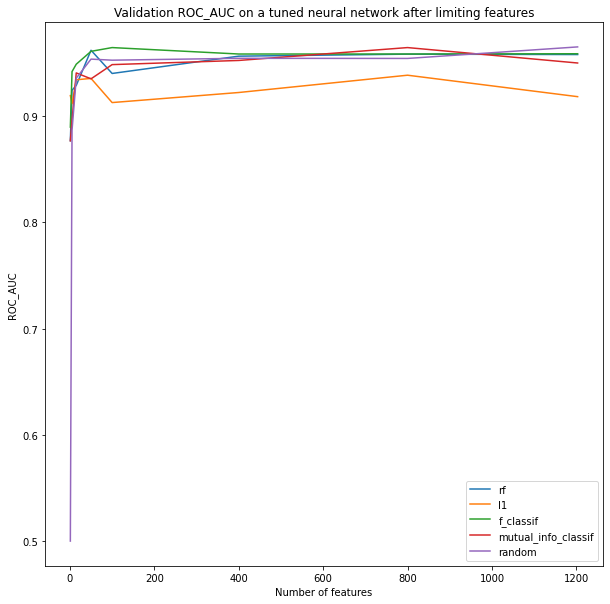

In [658]:
ax = accuracy_2.plot(figsize=(10, 10))
ax.set_title("Validation ROC_AUC on a tuned neural network after limiting features")
ax.set_xlabel("Number of features")
ax.set_ylabel("ROC_AUC")

Choose f_classif method of feature selection, with 100 features.
### Retune and retrain model

In [250]:
def model_builder_3(hp):

    model = keras.Sequential()
    model.add(Dense(100, input_shape=(100,), activation='relu'))

    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 2-length of layers
    hp_units = hp.Int('unit_1', min_value=2, max_value=2000, step=10)
    model.add(keras.layers.Dense(units=hp_units, activation='relu'))
    
    # dropout layer reduces overfitting
    hp_units = hp.Float('dropout_1', min_value=0.0, max_value=0.5, default=0.25, step=0.05)
    model.add(keras.layers.Dropout(hp_units))
    
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 2-length of layers
    hp_units = hp.Int('unit_2', min_value=2, max_value=2000, step=10)
    model.add(keras.layers.Dense(units=hp_units, activation='relu'))
    
    model.add(Dense(1, activation='sigmoid'))
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='binary_crossentropy',
                  metrics=METRICS)

    return model

In [262]:
import sklearn.feature_selection as fs
from sklearn.feature_selection import VarianceThreshold

constant_filter = VarianceThreshold(threshold=0)
constant_filter.fit(X_train_nn)
X_train_nn = constant_filter.transform(X_train_nn)
X_test_nn = constant_filter.transform(X_test_nn)
X_val_nn = constant_filter.transform(X_val_nn)
X_train_t_nn = constant_filter.transform(X_train_t_nn)


    
bk = fs.SelectKBest(fs.f_classif, k=100)
bk.fit(X_train_nn, y_train_nn)
X_train_nn = bk.transform(X_train_nn)

In [263]:
X_val_nn = bk.transform(X_val_nn)

In [264]:
X_test_nn = bk.transform(X_test_nn)

In [265]:
X_train_t_nn = bk.transform(X_train_t_nn)

In [266]:
print(X_val_nn.shape)
tuner = kt.Hyperband(model_builder_3,
                     objective=kt.Objective("val_auc", direction="max"),
                     max_epochs=10,
                     factor=3,
                     seed=SEED, 
                     directory="results_dir",
                     project_name="odor",
                     overwrite=True,)
                     
tuner.search(X_train_t_nn, 
             y_train_t_nn, 
             epochs=30,
             validation_data=(X_val_nn, y_val_nn),
             callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss")])

Trial 30 Complete [00h 00m 03s]
val_auc: 0.9563131332397461

Best val_auc So Far: 0.963762640953064
Total elapsed time: 00h 01m 04s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [267]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The hyperparameter search is complete. \n The optimal number of units in the first densely-connected
layer is {best_hps.get('unit_1')} \n The optimal number of units in the second densely-connected
layer is {best_hps.get('unit_2')} \n The optimal number of dropouts in the first densely-connected
layer is {best_hps.get('dropout_1')}.\n The optimal learning 
rate is  {best_hps.get('learning_rate')}
""")


The hyperparameter search is complete. 
 The optimal number of units in the first densely-connected
layer is 542 
 The optimal number of units in the second densely-connected
layer is 532 
 The optimal number of dropouts in the first densely-connected
layer is 0.30000000000000004.
 The optimal learning 
rate is  0.01



In [268]:
model4 = tuner.hypermodel.build(best_hps)
model4.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 100)               10100     
                                                                 
 dense_5 (Dense)             (None, 542)               54742     
                                                                 
 dropout_1 (Dropout)         (None, 542)               0         
                                                                 
 dense_6 (Dense)             (None, 532)               288876    
                                                                 
 dense_7 (Dense)             (None, 1)                 533       
                                                                 
Total params: 354,251
Trainable params: 354,251
Non-trainable params: 0
_________________________________________________________________


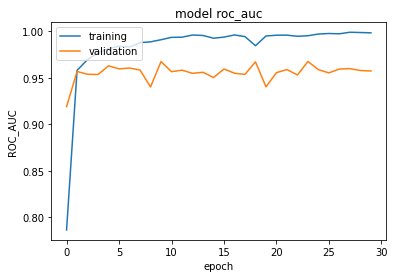

22/22 [==============================] - 0s 2ms/step


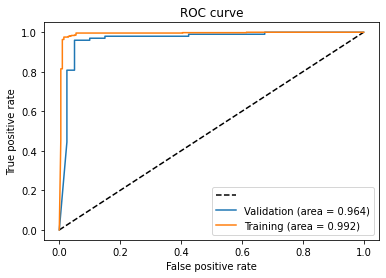

In [269]:
history = model4.fit(X_train_t_nn, 
                      y_train_t_nn, 
                      epochs=30,
                      batch_size=64,
                      validation_data=(X_val_nn, y_val_nn), 
                      verbose=0)

test_model_keras(model4, history, X_val_nn, y_val_nn, X_train_nn, y_train_nn)

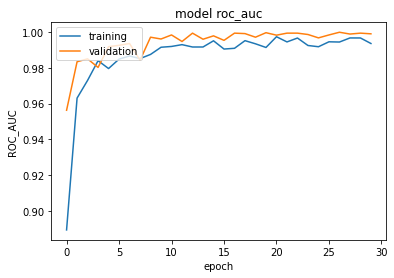

22/22 [==============================] - 0s 2ms/step


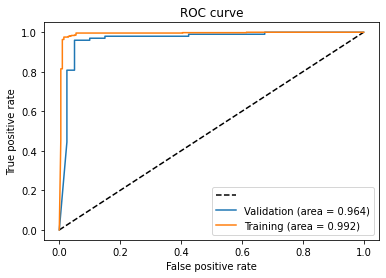

In [270]:
model_final = tuner.hypermodel.build(best_hps)

# Build the final model with all the training data with the optimal hyperparameters 
history = model_final.fit(X_train_nn, 
                      y_train_nn, 
                      epochs=30,
                      batch_size=64,
                      validation_data=(X_val_nn, y_val_nn), 
                      verbose=0)

test_model_keras(model4, history, X_val_nn, y_val_nn, X_train_nn, y_train_nn)

## Evaluate model on test data

6/6 [==============================] - 0s 2ms/step


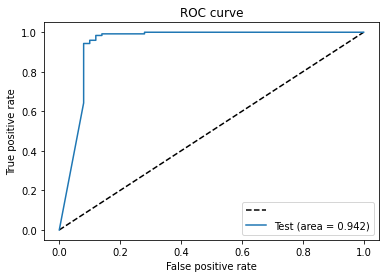

In [271]:
y_pred_t_keras = model_final.predict(X_test_nn).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test_nn, y_pred_t_keras)
auc_t_keras = metrics.roc_auc_score(y_test_nn, y_pred_t_keras)
auc_t_keras

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(['', 'Test (area = {:.3f})'.format(auc_t_keras)], loc='best')
plt.show()
plt.show()

# Penalized SVM

In [177]:
from sklearn import svm

y_train_svm = y_train.copy()
y_test_svm = y_test.copy()
X_train_svm, X_test_svm = handleNaNs(X_train.copy(), X_test.copy(), option=1)

In [178]:
clf_s = svm.SVC(kernel='linear',
                gamma='scale',
                class_weight='balanced', # penalize
                probability=True)

In [186]:
from sklearn.model_selection import RepeatedStratifiedKFold

print("Baseline CV=10 training performance of a SVM")

# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=SEED)
# evaluate model
scores = cross_val_score(clf_s, X_train_svm, y_train_svm, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % np.mean(scores))

Baseline CV=10 training performance of a SVM
Mean ROC AUC: 0.931


In [196]:
print("CV=5 training performance of a SVM with RF most important descriptors")

# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=SEED)
# evaluate model
scores = cross_val_score(clf_s, X_train_rf, y_train_rf, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % np.mean(scores))

CV=5 training performance of a SVM with RF most important descriptors
Mean ROC AUC: 0.941


ROC_AUC (TEST): 0.9557723577235772


CLASSIFICATION REPORT:
               precision    recall  f1-score   support

       False       0.83      0.90      0.87        50
        True       0.96      0.93      0.94       123

    accuracy                           0.92       173
   macro avg       0.90      0.91      0.90       173
weighted avg       0.92      0.92      0.92       173



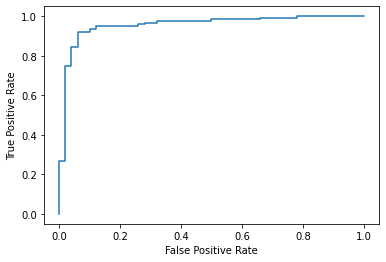

0.9557723577235772

In [198]:
clf_s.fit(X_train_rf, y_train_rf)
test_model(clf_s, y_test_rf, X_test_rf)